# Introduction

This notebook is designed to generate the LCA results and figures.

The analysis is based on the brightway project created with the notebook `1_mattress_database_creation` and supplemented with `2_hv_motor_database_creation`.

# Library import

In [1]:
#brightway
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import bw2analyzer as bwa

#matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker

#others
import numpy as np
import pandas as pd
import random
import math
import collections

#own functions
from utilities_bw2 import *

# Project setup

In [2]:
bd.projects

Brightway2 projects manager with 16 objects:
	ABB case
	Electric motors
	Motor case
	New motor case
	WT01
	ab_demo
	ab_demo_solution
	advlca24
	brightway2_test
	brightway_demo
	default
	lca_algebraic_handbook
	lifetime_test
	motor_case
	pLCA course
	test_240410
Use `projects.report()` to get a report on all projects.

In [3]:
bd.projects.set_current("lifetime_test")

In [4]:
bd.databases

Databases dictionary with 9 object(s):
	biosphere3
	ecoinvent_391_cutoff
	eol_treatment
	furniture_production
	mattress_production
	motor_production
	motor_production_simplified
	packaging
	primary_production

In [5]:
mattress_db = bd.Database("mattress_production")

In [6]:
motor_db = bd.Database("motor_production")

# Selection of impact categories

The study uses the impact assessment methods from the environmental footprint method EF v3.1 as implemented in encoinvent 3.9.1.

**EF impact categories**

In [7]:
ef_methods = [m for m in bd.methods if 'EF v3.1' in str(m) and 'no LT' not in str(m) and 'EN15804' not in str(m)]

In [8]:
ef_gw_method = [m for m in ef_methods if 'climate change' in m][0]

In [9]:
ef_adp_method = [m for m in ef_methods if "material resources: metals/minerals" in m][0]

**Selection**

Results are generated for one environmental impact category. The chosen environmental impact category is global warming for the article but abiodic depletion elements can also be tested.

In [10]:
def choice_impact_categories(choice):
    if choice == "gw":
        factors_for_figures = {
            "y_lim": {"mattresses": 20, "motors": 200000, "cups": 0.1}, 
            "ticker_locator": {"mattresses": 2, "motors": 10000, "cups": 0.01},
            "lifetime_max": {"mattresses": 20, "motors": 30, "cups": 30}
        }
        return [ef_gw_method], "Global warming (kg CO2 eq)", "kg CO2 eq", "gw", factors_for_figures
    elif choice == "adp":
        factors_for_figures = {
            "y_lim": {"mattresses": 0.0002, "motors": 10, "cups": 3e-7}, 
            "ticker_locator": {"mattresses": 0.00002, "motors": 2, "cups": 5e-8},
            "lifetime_max": {"mattresses": 20, "motors": 40, "cups": 50}
        }
        return [ef_adp_method], "Abiotic depletion - elements (kg Sb eq)", "kg Sb eq", "adp", factors_for_figures

In [11]:
chosen_methods, methods_label, methods_unit, methods_code, factors_for_figures = choice_impact_categories("gw")

# LCIA

## Selection of activities

**Spring mattress**

In [12]:
act_mattress_production = mattress_db.search("spring mattress production RER")[0]

In [13]:
act_mattress_eol = mattress_db.search("spring mattress end-of-life treatment RER")[0]

In [14]:
act_mattress_refurbish = mattress_db.search("spring mattress refurbishment RER")[0]

**HV motor**

In [15]:
act_im_motor_production = motor_db.search("IM motor production SE")[0]

In [16]:
act_im_motor_use = motor_db.search("IM motor use for one year SE")[0]

In [17]:
act_im_motor_eol = motor_db.search("IM motor end-of-life treatment SE")[0]

In [18]:
act_im_motor_repair = motor_db.search("IM rewinding SE")[0]

## Impact calculations

Generation of LCIA results for each life cycle phase for each product.

In [19]:
def lcia_calculations_product(act_production, act_eol, act_repair, act_use=None, amount=1, chosen_methods=chosen_methods):
    if act_use is None:
        return lca_results({act_production: amount}, chosen_methods), lca_results({act_eol: amount}, chosen_methods), lca_results({act_repair: amount}, chosen_methods)
    else:
        return lca_results({act_production: amount}, chosen_methods), lca_results({act_eol: amount}, chosen_methods), lca_results({act_repair: amount}, chosen_methods), lca_results({act_use: amount}, chosen_methods)

**Spring mattress**

In [20]:
lcia_mattress_production, lcia_mattress_eol, lcia_mattress_refurbish = lcia_calculations_product(act_mattress_production, act_mattress_eol, act_mattress_refurbish)

**HV motor**

In [21]:
lcia_im_motor_production, lcia_im_motor_eol, lcia_im_motor_repair, lcia_im_motor_use = lcia_calculations_product(
    act_im_motor_production, 
    act_im_motor_eol, 
    act_im_motor_repair, 
    act_use=act_im_motor_use
)

# Analysis

## With a single value

### Lifetime data

**Mattress**

10 years is used by the ADEME (2017). The standard on bedding products also reports lifetime values between 5 and 20 years depending on the product. Here, the baseline is chosen as 8.3 years, the average value found in a survey to adults living in the US [(link)](https://bedtimesmagazine.com/2023/02/mattress-replacement-cycle-drops-to-8-3-years/) in 2022.

In [22]:
mattress_lifetime_value_baseline = 8.3 #years

In [23]:
mattress_lifetime_value_min = 4 #years

In [24]:
mattress_lifetime_value_max = 20 #years

**HV motors**

Little data is available about HV motor lifetime. For the largest motors found in the literature, the average lifetime is 20 years (Almeida et al. 2008, Walters 2000), with values up to 38 years in one article (Hasanuzzaman et al. 2011). Here, the baseline is chosen as 20 years.

In [25]:
motor_lifetime_value_baseline = 20 #years

In [26]:
motor_lifetime_value_max = 40 #years (38 years rounded up to 40)

In [27]:
motor_lifetime_value_min = 1 #years (for testing a very low value)

### Environmental impact data

Function to generate LCA results for the mattress for given lifetime and additional lifetime values.

In [28]:
def mattress_dataframe_lca_results_lifetime_value(lifetime_value, df_production, df_eol, df_repair=None, add_lifetime_value=None):
    if df_repair is not None:
        impact_production = df_production.loc[0, "score"] / (lifetime_value + add_lifetime_value)
        impact_eol = df_eol.loc[0, "score"] / (lifetime_value + add_lifetime_value)
        impact_repair = df_repair.loc[0, "score"] / (lifetime_value + add_lifetime_value)
        return pd.DataFrame([[impact_production], [impact_repair], [impact_eol]], index=["production", "remanufacturing", "end-of-life treatment"], columns=["impact"])
    else:
        impact_production = df_production.loc[0, "score"] / lifetime_value
        impact_eol = df_eol.loc[0, "score"] / lifetime_value
        return pd.DataFrame([[impact_production], [impact_eol]], index=["production", "end-of-life treatment"], columns=["impact"])

Functions to generate a table of values to plot for the mattress, each row being a different scenario (initial and additional lifetime values), and the corresponding x-axis legend. The following function provides LCA results per year of use, the second function provides results per mattress.

In [29]:
def mattress_scenarios_to_plot(list_baseline_lifetime, list_refurbishment_lifetime, df_production=lcia_mattress_production, df_eol=lcia_mattress_eol, df_repair=lcia_mattress_refurbish):
    data_to_plot = []
    x_axis_legend = []
    for lifetime in list_baseline_lifetime:
        data_to_plot += [mattress_dataframe_lca_results_lifetime_value(lifetime, df_production, df_eol)]
        x_axis_legend += ["baseline\n(" + str(lifetime) + " y.)"]
    for lifetime, add_lifetime in list_refurbishment_lifetime:
        data_to_plot += [mattress_dataframe_lca_results_lifetime_value(lifetime, df_production, df_eol, df_repair=df_repair, add_lifetime_value=add_lifetime)]
        x_axis_legend += ["reman.\n(" + str(lifetime) + "+" + str(add_lifetime) + " y.)"]
    return data_to_plot, x_axis_legend

In [30]:
def mattress_scenarios_to_plot_per_product(list_baseline_lifetime, list_refurbishment_lifetime, df_production=lcia_mattress_production, df_eol=lcia_mattress_eol, df_repair=lcia_mattress_refurbish):
    data_to_plot = []
    x_axis_legend = []
    for lifetime in list_baseline_lifetime:
        data_to_plot += [mattress_dataframe_lca_results_lifetime_value(1, df_production, df_eol)]
        #x_axis_legend += ["no reman.\n(" + str(lifetime) + " years)"]
    for lifetime, add_lifetime in list_refurbishment_lifetime:
        data_to_plot += [mattress_dataframe_lca_results_lifetime_value(1, df_production, df_eol, df_repair=df_repair, add_lifetime_value=0)]
        #x_axis_legend += ["reman.\n(" + str(lifetime) + "+" + str(add_lifetime) + " years)"]
    return data_to_plot

Function to generate LCA results for the motor for given lifetime and additional lifetime values.

In [31]:
def dataframe_lca_results_lifetime_value(lifetime_value, df_production, df_eol, df_use=None, df_repair=None, add_lifetime_value=None):
    if df_use is not None:
        impact_use = df_use.loc[0, "score"]
    else:
        impact_use = 0
    if df_repair is not None:
        impact_production = df_production.loc[0, "score"] / (lifetime_value + add_lifetime_value)
        impact_eol = df_eol.loc[0, "score"] / (lifetime_value + add_lifetime_value)
        impact_repair = df_repair.loc[0, "score"] / (lifetime_value + add_lifetime_value)
        return pd.DataFrame([[impact_use], [impact_production], [impact_repair], [impact_eol]], index=["use", "production", "repair", "end-of-life treatment"], columns=["impact"])
    else:
        impact_production = df_production.loc[0, "score"] / lifetime_value
        impact_eol = df_eol.loc[0, "score"] / lifetime_value
        return pd.DataFrame([[impact_use], [impact_production], [impact_eol]], index=["use", "production", "end-of-life treatment"], columns=["impact"])

Functions to generate a table of values to plot for the motor, each row being a different scenario (initial and additional lifetime values), and the corresponding x-axis legend. The following function provides LCA results per year of use, the second function provides results per mattress.

In [32]:
def motor_scenarios_to_plot(list_baseline_lifetime, list_refurbishment_lifetime, df_production=lcia_im_motor_production, df_use=lcia_im_motor_use, df_eol=lcia_im_motor_eol, df_repair=lcia_im_motor_repair):
    data_to_plot = []
    x_axis_legend = []
    for lifetime in list_baseline_lifetime:
        data_to_plot += [dataframe_lca_results_lifetime_value(lifetime, df_production, df_eol, df_use=df_use)]
        x_axis_legend += ["baseline\n(" + str(lifetime) + " y.)"]
    for lifetime, add_lifetime in list_refurbishment_lifetime:
        data_to_plot += [dataframe_lca_results_lifetime_value(lifetime, df_production, df_eol, df_use=df_use, df_repair=df_repair, add_lifetime_value=add_lifetime)]
        x_axis_legend += ["repair\n(" + str(lifetime) + " + " + str(add_lifetime) + " y.)"]
    return data_to_plot, x_axis_legend

In [33]:
def motor_scenarios_to_plot_per_product(list_baseline_lifetime, list_refurbishment_lifetime, df_production=lcia_im_motor_production, df_use=lcia_im_motor_use, df_eol=lcia_im_motor_eol, df_repair=lcia_im_motor_repair):
    data_to_plot = []
    for lifetime in list_baseline_lifetime:
        data_to_plot += [pd.DataFrame(
            [[df_eol.loc[0, "score"] * lifetime], [df_production.loc[0, "score"]], [df_eol.loc[0, "score"]]], 
            index=["use", "production", "end-of-life treatment"], 
            columns=["impact"]
        )]
    for lifetime, add_lifetime in list_refurbishment_lifetime:
        data_to_plot += [pd.DataFrame(
            [[df_eol.loc[0, "score"] * (lifetime + add_lifetime)], [df_production.loc[0, "score"]], [df_repair.loc[0, "score"]], [df_eol.loc[0, "score"]]], 
            index=["use", "production", "repair", "end-of-life treatment"], 
            columns=["impact"]
        )]
    return data_to_plot

### Figure in the manuscript

In [34]:
def mattress_article_figure_data_to_plot(list_scenarios, df_production=lcia_mattress_production, df_eol=lcia_mattress_eol, df_repair=lcia_mattress_refurbish):
    data_to_plot = []
    data_to_plot_per_product = []
    x_axis_legend = []
    x_axis_value = []
    increment_x_axis = 0
    time_for_new_increment = False
    for scenario in list_scenarios:
        if len(scenario) == 1:
            if time_for_new_increment:
                increment_x_axis += 0.4
                time_for_new_increment = False
            # Generate data
            data, legend = mattress_scenarios_to_plot([scenario[0]], [], df_production=df_production, df_eol=df_eol, df_repair=df_repair)
            data_to_plot_per_product += mattress_scenarios_to_plot_per_product([scenario[0]], [], df_production=df_production, df_eol=df_eol, df_repair=df_repair)
        else:
            time_for_new_increment = True
            # Generate data
            data, legend = mattress_scenarios_to_plot([], [scenario], df_production=df_production, df_eol=df_eol, df_repair=df_repair)
            data_to_plot_per_product += mattress_scenarios_to_plot_per_product([], [scenario], df_production=df_production, df_eol=df_eol, df_repair=df_repair)
        # Add data to the lists
        data_to_plot += data
        x_axis_legend += legend
        # x-axis value
        x_axis_value += [len(x_axis_value) + increment_x_axis]
    return [data_to_plot_per_product, data_to_plot], x_axis_legend, x_axis_value

In [35]:
def motor_article_figure_data_to_plot(list_scenarios, df_production=lcia_im_motor_production, df_eol=lcia_im_motor_eol, df_repair=lcia_im_motor_repair, df_use=lcia_im_motor_use):
    data_to_plot = []
    data_to_plot_per_product = []
    x_axis_legend = []
    x_axis_value = []
    increment_x_axis = 0
    time_for_new_increment = False
    for scenario in list_scenarios:
        if len(scenario) == 1:
            if time_for_new_increment:
                increment_x_axis += 0.4
                time_for_new_increment = False
            # Generate data
            data, legend = motor_scenarios_to_plot([scenario[0]], [], df_production=df_production, df_eol=df_eol, df_repair=df_repair, df_use=df_use)
            data_to_plot_per_product += motor_scenarios_to_plot_per_product([scenario[0]], [], df_production=df_production, df_eol=df_eol, df_repair=df_repair, df_use=df_use)
        else:
            time_for_new_increment = True
            # Generate data
            data, legend = motor_scenarios_to_plot([], [scenario], df_production=df_production, df_eol=df_eol, df_repair=df_repair, df_use=df_use)
            data_to_plot_per_product += motor_scenarios_to_plot_per_product([], [scenario], df_production=df_production, df_eol=df_eol, df_repair=df_repair, df_use=df_use)
        # Add data to the lists
        data_to_plot += data
        x_axis_legend += legend
        # x-axis value
        x_axis_value += [len(x_axis_value) + increment_x_axis]
    return [data_to_plot_per_product, data_to_plot], x_axis_legend, x_axis_value

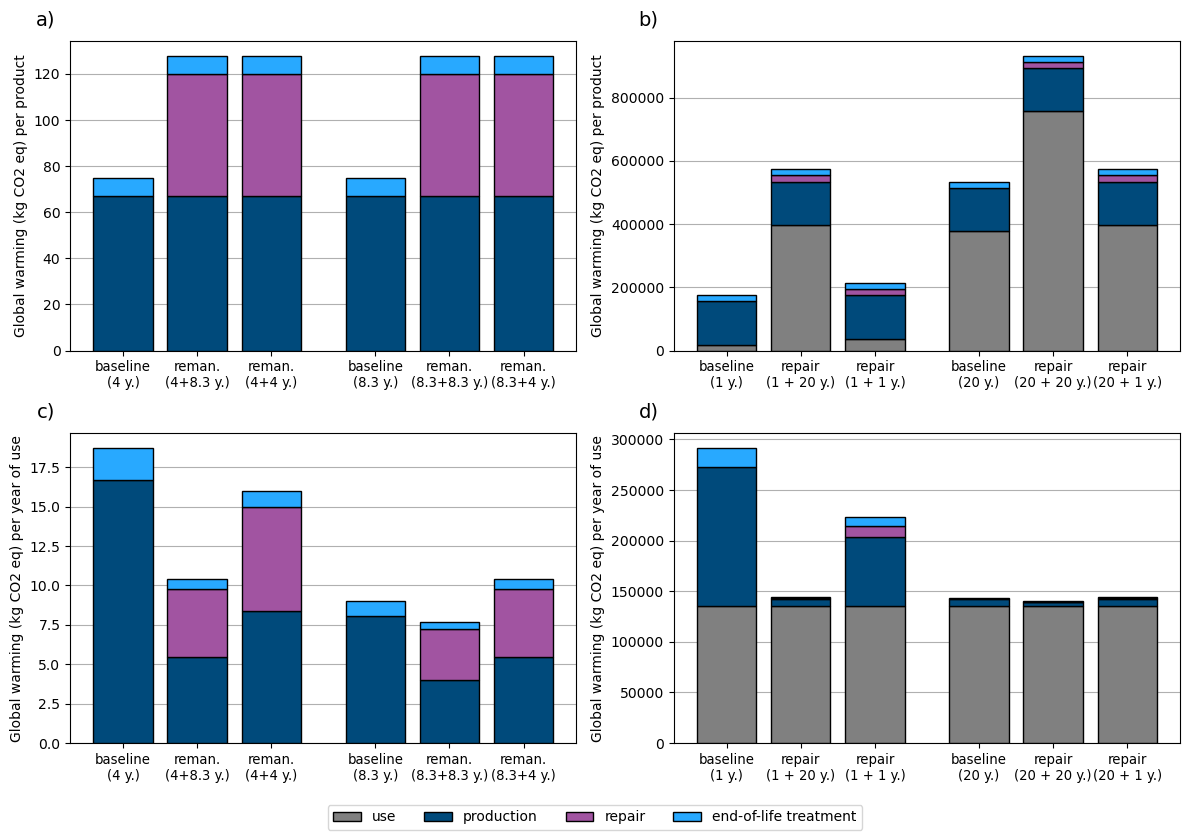

In [37]:
# Figure colors
figure_colors = {
    "production": "#004A7B",
    "end-of-life treatment": "#28A9FF",
    "remanufacturing": "#A154A1",
    "repair": "#A154A1",
    "use": "gray"
}

# Set figure size
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

# Parameters for the figure
width_bar = 0.8 #width of the bars, should be <1

# List of data to plot for the mattress
scenario_list = [
    (mattress_lifetime_value_min,),
    (mattress_lifetime_value_min, mattress_lifetime_value_baseline),
    (mattress_lifetime_value_min, mattress_lifetime_value_min),
    (mattress_lifetime_value_baseline,), 
    (mattress_lifetime_value_baseline, mattress_lifetime_value_baseline), 
    (mattress_lifetime_value_baseline, mattress_lifetime_value_min)
]

data_to_plot, x_axis_legend, x_values = mattress_article_figure_data_to_plot(scenario_list)

# Figures for the mattress
for n_fig in range(2):
    for n_bar, data in enumerate(data_to_plot[n_fig]):
        for i, activity in enumerate(data.index):
            ax[n_fig,0].bar(
                x_values[n_bar], 
                data.loc[activity, "impact"], 
                bottom=data.iloc[:i,0].sum(), 
                color=figure_colors[activity], width=width_bar, edgecolor="black",
                zorder=10
            )

# List of data to plot for the motor
scenario_list = [
    (motor_lifetime_value_min,),
    (motor_lifetime_value_min, motor_lifetime_value_baseline),
    (motor_lifetime_value_min, motor_lifetime_value_min),
    (motor_lifetime_value_baseline,), 
    (motor_lifetime_value_baseline, motor_lifetime_value_baseline), 
    (motor_lifetime_value_baseline, motor_lifetime_value_min)
]

data_to_plot_motor, x_axis_legend_motor, x_values_motor = motor_article_figure_data_to_plot(scenario_list)

# Figures for the motor
for n_fig in range(2):
    for n_bar, data in enumerate(data_to_plot_motor[n_fig]):
        for i, activity in enumerate(data.index):
            if n_bar == len(data_to_plot) - 1 and n_fig == 1:
                ax[n_fig,1].bar(
                    x_values_motor[n_bar], 
                    data.loc[activity, "impact"], 
                    bottom=data.iloc[:i,0].sum(), 
                    label=activity, 
                    color=figure_colors[activity], width=width_bar, edgecolor="black",
                    zorder=10
                )
            else:
                ax[n_fig,1].bar(
                    x_values_motor[n_bar], 
                    data.loc[activity, "impact"], 
                    bottom=data.iloc[:i,0].sum(), 
                    color=figure_colors[activity], width=width_bar, edgecolor="black",
                    zorder=10
                )

# Add legend, title, and labels
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0), ncol=4)
for n, text in enumerate(["a)", "b)", "c)" , "d)"]):
    ax[n//2, n%2].annotate(text, xy=(-0.03, 1.1), xycoords='axes fraction', fontsize=14, ha='right', va='top')
    # Turn on gridlines
    ax[n//2, n%2].grid(axis="y", zorder=0)
for n_fig in range(2):
    ax[0,n_fig].set_ylabel(methods_label + ' per product')
    ax[1,n_fig].set_ylabel(methods_label + ' per year of use')
for n_fig in range(2):
    ax[n_fig,0].set_xticks(x_values, x_axis_legend, fontsize=9.5)
for n_fig in range(2):
    ax[n_fig, 1].set_xticks(x_values_motor, x_axis_legend_motor, fontsize=9.5)

# Remove white margins
plt.tight_layout()

# Save the plot
fig.savefig("figures\\article_" + methods_code + "_scenarios.svg", bbox_inches='tight')

# Show the plot
plt.show()

### Figures in SI

In [38]:
# Figure colors
figure_colors = {
    "production": "#004A7B",
    "end-of-life treatment": "#28A9FF",
    "remanufacturing": "#A154A1",
    "repair": "#A154A1",
    "use": "gray"
}

def article_si_figure_single_values(product_name, lifetime_list, methods_code=methods_code, methods_label=methods_label):
    # Set figure size
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
    
    # Parameters for the figure
    width_bar = 0.8 #width of the bars, should be <1
    
    # List of data to plot
    scenario_list = []
    for lifetime in lifetime_list:
        scenario_list.append((lifetime,))
        for add_lifetime in lifetime_list:
            scenario_list.append((lifetime, add_lifetime))

    if product_name == "mattress":
        data_to_plot, x_axis_legend, x_values = mattress_article_figure_data_to_plot(scenario_list)
    elif product_name == "motor":
        data_to_plot, x_axis_legend, x_values = motor_article_figure_data_to_plot(scenario_list)
    
    # Figure
    for n_fig in range(2):
        for n_bar, data in enumerate(data_to_plot[n_fig]):
            for i, activity in enumerate(data.index):
                if n_bar == len(data_to_plot) - 1 and n_fig == 1:
                    ax[n_fig].bar(
                        x_values[n_bar], 
                        data.loc[activity, "impact"], 
                        bottom=data.iloc[:i,0].sum(), 
                        label=activity, 
                        color=figure_colors[activity], width=width_bar, edgecolor="black",
                        zorder=10
                    )
                else:
                    ax[n_fig].bar(
                        x_values[n_bar], 
                        data.loc[activity, "impact"], 
                        bottom=data.iloc[:i,0].sum(), 
                        color=figure_colors[activity], width=width_bar, edgecolor="black",
                        zorder=10
                    )
    
    # Add legend, title, and labels
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    ax[0].annotate("a)", xy=(-0.03, 1.1), xycoords='axes fraction', fontsize=14, ha='right', va='top')
    ax[1].annotate("b)", xy=(-0.03, 1.1), xycoords='axes fraction', fontsize=14, ha='right', va='top')
    ax[0].set_ylabel(methods_label + ' per product')
    ax[1].set_ylabel(methods_label + ' per year of use')
    for n_fig in range(2):
        ax[n_fig].set_xticks(x_values, x_axis_legend, fontsize=9.5)
        # Turn on gridlines
        ax[n_fig].grid(axis="y", zorder=0)
    
    # Remove white margins
    plt.tight_layout()
    
    # Save the plot
    fig.savefig("figures\\article_si_" + methods_code + "_" + product_name + "_scenarios.svg", bbox_inches='tight')
    
    # Show the plot
    return plt.show()

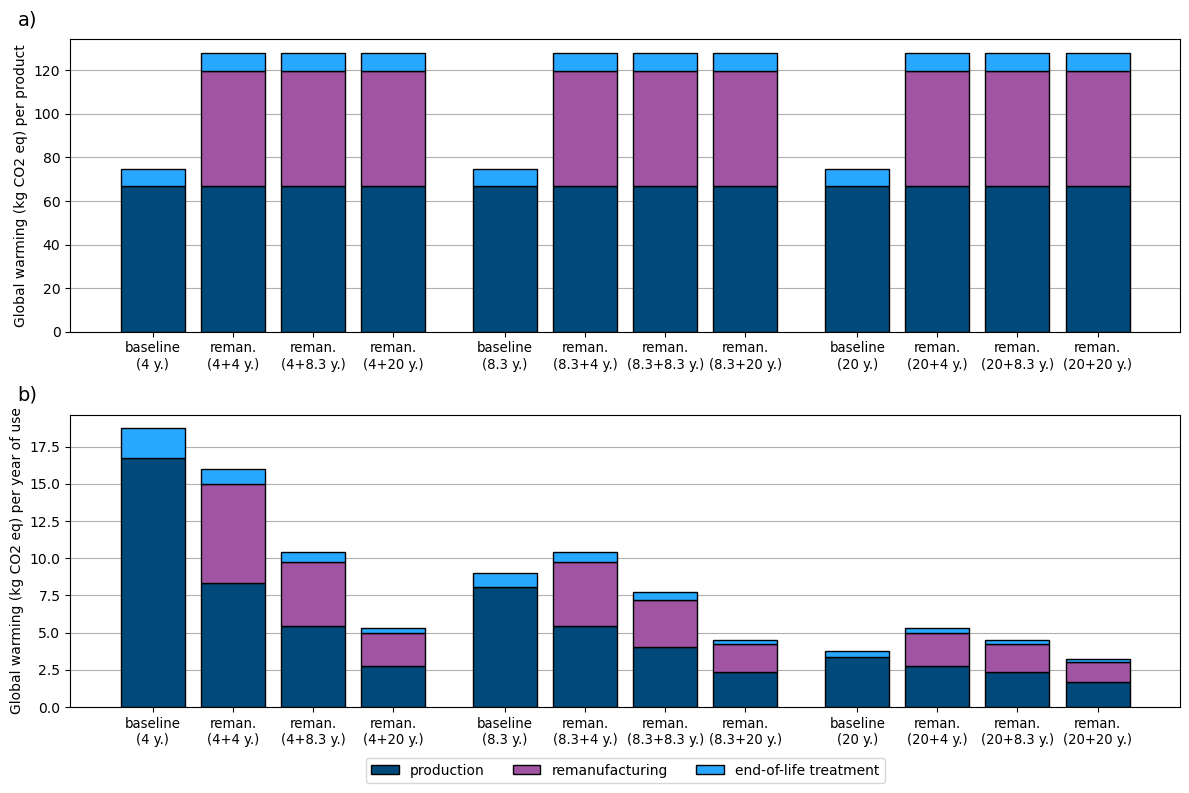

In [39]:
article_si_figure_single_values(
    "mattress",
    [mattress_lifetime_value_min, mattress_lifetime_value_baseline, mattress_lifetime_value_max]
)

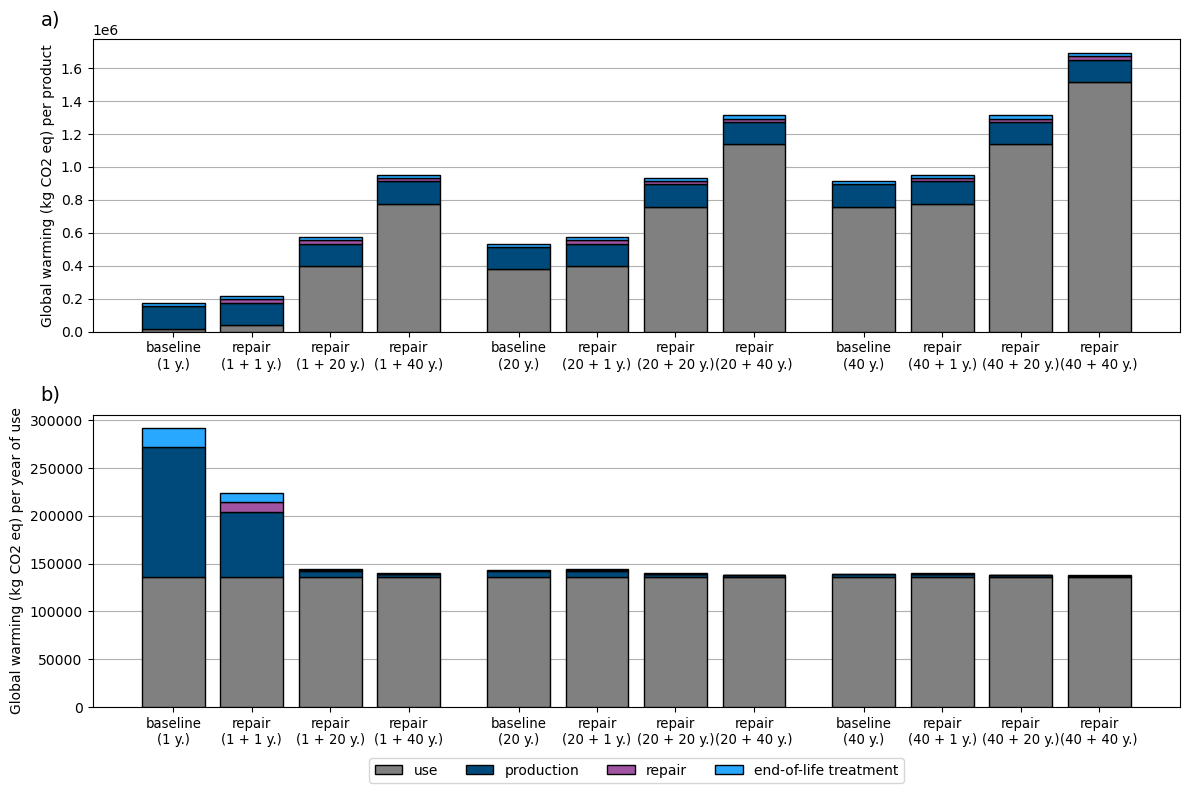

In [40]:
article_si_figure_single_values(
    "motor",
    [motor_lifetime_value_min, motor_lifetime_value_baseline, motor_lifetime_value_max]
)

## With no-fixed value

No data on the lifetime is required.

### Break-even values and figure with breakeven slope

In [41]:
def calculation_breakeven_value_factor(df_production, df_eol, df_repair):
    return df_repair.loc[0, "score"] / (df_production.loc[0, "score"] + df_eol.loc[0, "score"])

In [42]:
def article_figure_breakeven_slope(ax, label, lcia_production, lcia_eol, lcia_repair, lifetime_max, line_color):
    # Values to be plotted
    slope_breakeven = calculation_breakeven_value_factor(
        lcia_production, 
        lcia_eol, 
        lcia_repair
    )
    x = np.linspace(0, lifetime_max, 1000)
    y = slope_breakeven * x
    
    # Plot the data
    ax.plot(
        x, y,  # Values
        color=line_color,  # Color
        label=label,
        zorder=10  # Move forward in the order of layers on the figure (behind gridlines)
    )

In [43]:
def article_figure_example_breakeven(ax, label, lcia_production, lcia_eol, lcia_repair, lifetime_max, line_color, lifetime_example, stop_label=False):
    # Values to be plotted
    slope_breakeven = calculation_breakeven_value_factor(
        lcia_production, 
        lcia_eol, 
        lcia_repair
    )

    # Plot the example
    if stop_label:
        ax.axvline(x=lifetime_example, ymax=lifetime_example*slope_breakeven/22, color="gray", linestyle="--")
    else:
        ax.axvline(x=lifetime_example, ymax=lifetime_example*slope_breakeven/22, label="Example: initial lifetime of " + str(lifetime_example) + " years", color="gray", linestyle="--")
    ax.axhline(y=lifetime_example*slope_breakeven, xmax=lifetime_example/lifetime_max, label="Break-even value for the additional lifetime\nof " + "{:.1f}".format(slope_breakeven * lifetime_example) + " years for the " + label, color=line_color, linestyle="--")

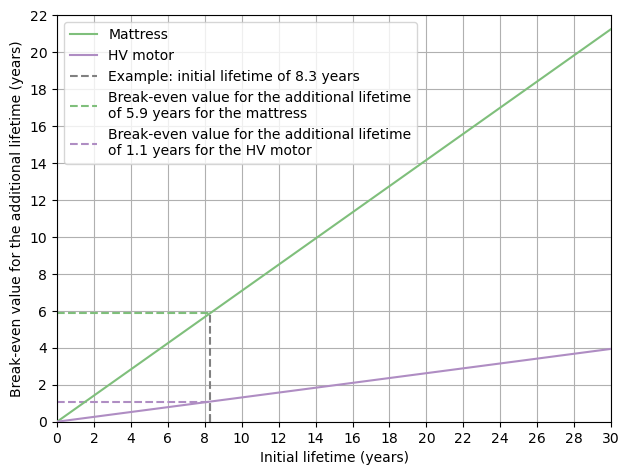

In [44]:
# Set up the figure and axis
fig, ax = plt.subplots()

list_colors_breakeven = ["#af8dc3", "#7fbf7b"]

# Plot figures
article_figure_breakeven_slope(
    ax,
    "Mattress",
    lcia_mattress_production,
    lcia_mattress_eol,
    lcia_mattress_refurbish,
    30,
    list_colors_breakeven[1]
)
article_figure_breakeven_slope(
    ax,
    "HV motor",
    lcia_im_motor_production,
    lcia_im_motor_eol,
    lcia_im_motor_repair,
    30,
    list_colors_breakeven[0]
)
# Plot examples
article_figure_example_breakeven(
    ax,
    "mattress",
    lcia_mattress_production,
    lcia_mattress_eol,
    lcia_mattress_refurbish,
    30,
    list_colors_breakeven[1],
    mattress_lifetime_value_baseline
)
article_figure_example_breakeven(
    ax,
    "HV motor",
    lcia_im_motor_production,
    lcia_im_motor_eol,
    lcia_im_motor_repair,
    30,
    list_colors_breakeven[0],
    mattress_lifetime_value_baseline,
    stop_label=True
)
    
# Add title and labels
plt.legend()
ax.set_xlabel('Initial lifetime (years)')
ax.set_ylabel('Break-even value for the additional lifetime (years)')
    
# Change format of x-axis tick labels
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
    
# Turn on gridlines
ax.grid(zorder=0)
    
# Set equal aspect ratio
ax.set_aspect('equal')
    
# Set the x-axis and y-axis limits to start at 0
ax.set_xlim(left=0, right=30)
ax.set_ylim(bottom=0, top=22)

# Remove white margins
plt.tight_layout()

# Save the plot
fig.savefig("figures\\article_" + methods_code + "_breakeven.svg")

# Show the plot
plt.show()

### Figure in manuscript (mattress)

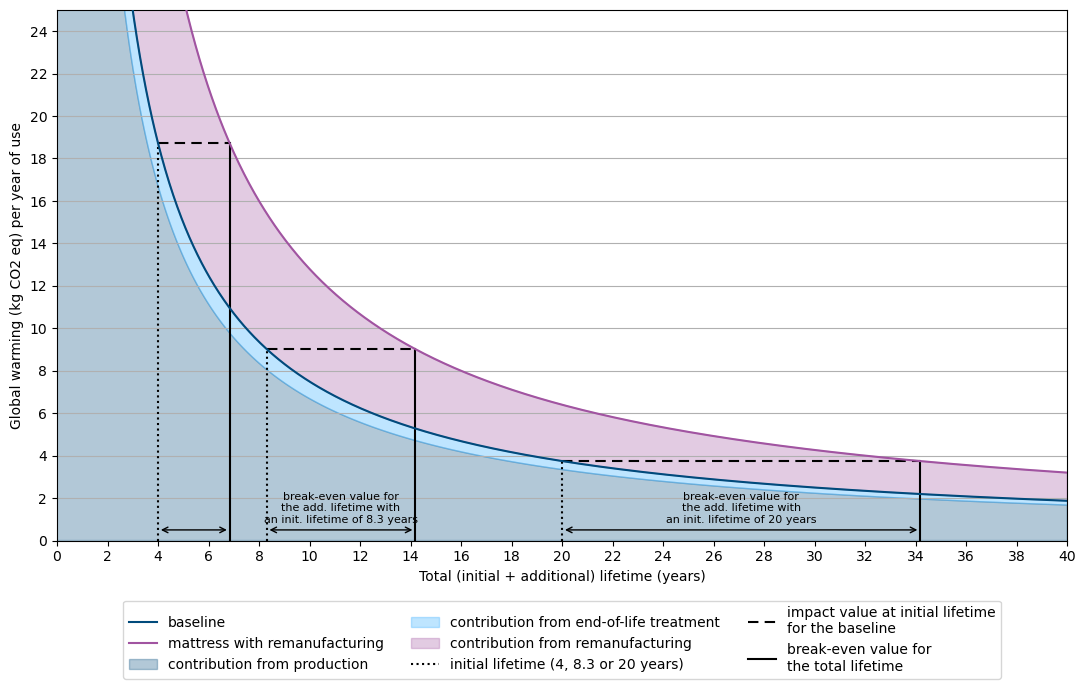

In [45]:
# Parameters on the figure
figure_list_lifetime = [mattress_lifetime_value_min, mattress_lifetime_value_baseline, mattress_lifetime_value_max]
#figure_list_colors = ["#1b9e77", "#d95f02", "#e7298a"]
figure_list_colors = ["black" for i in range(3)]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(11,7))
    
# Parameters for having nice plots
figure_lifetime_max = 40
y_lim = 25
    
# Data in common with all plots
slope_breakeven = calculation_breakeven_value_factor(
    lcia_mattress_production, 
    lcia_mattress_eol, 
    lcia_mattress_refurbish
)

# Values for lines
x_baseline = np.linspace(0.001, figure_lifetime_max, 1000)
y_baseline = (lcia_mattress_production.loc[0, "score"] + lcia_mattress_eol.loc[0, "score"]) / x_baseline
y_ce = (lcia_mattress_production.loc[0, "score"] + lcia_mattress_eol.loc[0, "score"] + lcia_mattress_refurbish.loc[0, "score"]) / x_baseline
y_at_lifetime = []
for i, lifetime in enumerate(figure_list_lifetime):
    y_at_lifetime += [(lcia_mattress_production.loc[0, "score"] + lcia_mattress_eol.loc[0, "score"]) / lifetime]

# Values for the contributions
y_production = lcia_mattress_production.loc[0, "score"] / x_baseline

# Plot the lines
ax.plot(
    x_baseline, y_baseline,  # Values
    color="#004A7B",  # Color
    label="baseline", # Label for the lengend
    zorder=10  # Move forward in the order of layers on the figure (behind gridlines)
)
ax.plot(
    x_baseline, y_ce,  # Values
    color="#A154A1",  # Color
    label="mattress with remanufacturing", # Label for the lengend
    zorder=10  # Move forward in the order of layers on the figure (behind gridlines)
)

# Plot the contributions
ax.fill_between(x_baseline, y_production, color="#004A7B", alpha=0.3, label="contribution from production")
ax.fill_between(x_baseline, y_baseline, y_production, color="#28A9FF", alpha=0.3, label="contribution from end-of-life treatment")
ax.fill_between(x_baseline, y_ce, y_baseline, color="#A154A1", alpha=0.3, label="contribution from remanufacturing")

# Plot the break-even values
for i, lifetime in enumerate(figure_list_lifetime):
    if i == 0:
        ax.axvline(
            x=lifetime, 
            ymin=0, ymax=y_at_lifetime[i]/y_lim, 
            color=figure_list_colors[i], linestyle=':', label="initial lifetime (4, 8.3 or 20 years)"
        )
        ax.axhline(
            y=y_at_lifetime[i], 
            xmin=lifetime/figure_lifetime_max, xmax=(1 + slope_breakeven)*lifetime/figure_lifetime_max, 
            color=figure_list_colors[i], linestyle='--', dashes=(5, 3), label="impact value at initial lifetime\nfor the baseline"
        )
        ax.axvline(
            x=(1 + slope_breakeven)*lifetime,
            ymax=y_at_lifetime[i]/y_lim, 
            color=figure_list_colors[i], label="break-even value for\nthe total lifetime"
        )
    else:
        ax.axvline(x=lifetime, ymin=0, ymax=y_at_lifetime[i]/y_lim, color=figure_list_colors[i], linestyle=':')
        ax.axhline(y=y_at_lifetime[i], xmin=lifetime/figure_lifetime_max, xmax=(1 + slope_breakeven)*lifetime/figure_lifetime_max, color=figure_list_colors[i], linestyle='--', dashes=(5, 3))
        ax.axvline(x=(1 + slope_breakeven)*lifetime, ymax=y_at_lifetime[i]/y_lim, color=figure_list_colors[i])

# Pointing to break-even values
for i, lifetime in enumerate(figure_list_lifetime):
    ax.annotate(text='', xy=((1 + slope_breakeven)*lifetime, 0.5), xytext=(lifetime, 0.5), arrowprops=dict(arrowstyle='<->'))
    if i>0:
        ax.text(
            (2 + slope_breakeven)*lifetime/2, 0.75, 
            "break-even value for\nthe add. lifetime with\nan init. lifetime of " + str(lifetime) + " years", 
            horizontalalignment='center', verticalalignment='bottom', fontsize=8
        )

# Add legend, title and labels
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set_xlabel('Total (initial + additional) lifetime (years)')
ax.set_ylabel(methods_label + ' per year of use')

# Change format of x-axis tick labels
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) #scientific notation for the labels
    
# Turn on gridlines
ax.grid(axis='y', zorder=0)
    
# Set the x-axis and y-axis limits to start at 0
ax.set_xlim(left=0, right=figure_lifetime_max)
ax.set_ylim(bottom=0, top=y_lim)
    
# Remove white margins
plt.tight_layout()
    
# Save the plot
fig.savefig("figures\\article_" + methods_code + "_" + "mattresses" + "_parameter.svg", bbox_inches='tight')
    
# Show the plot
plt.show()

### Figure in SI (motor)

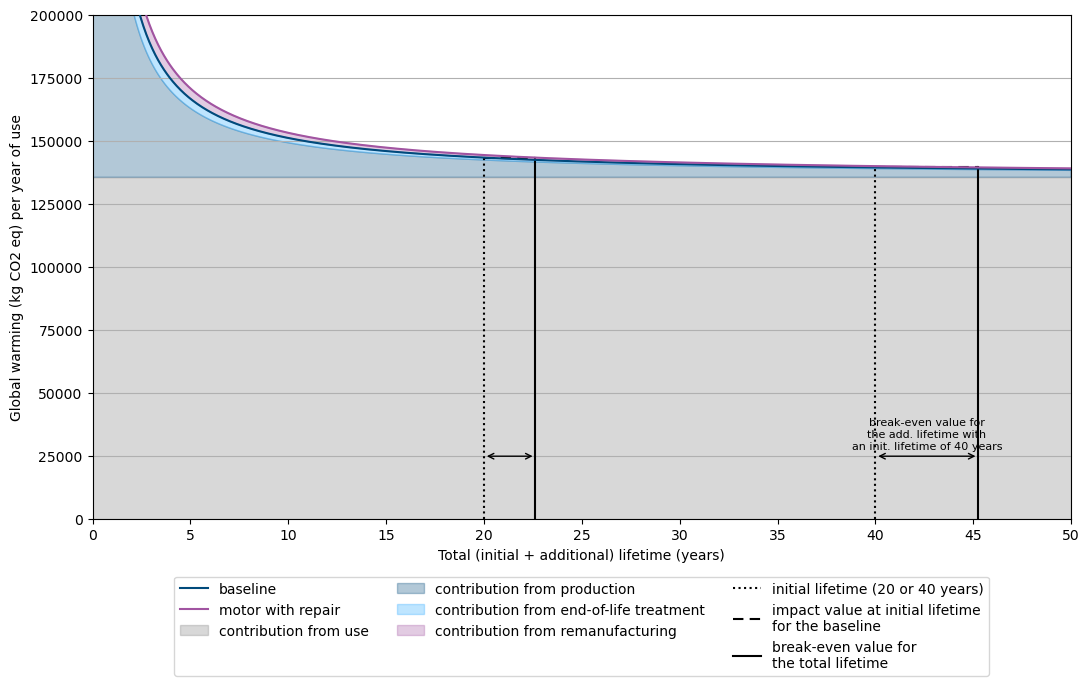

In [46]:
# Parameters on the figure
figure_list_lifetime = [motor_lifetime_value_baseline, motor_lifetime_value_max]
#figure_list_colors = ["#1b9e77", "#d95f02", "#e7298a"]
figure_list_colors = ["black" for i in range(3)]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(11,7))
    
# Parameters for having nice plots
figure_lifetime_max = 50
y_lim = 2E5
    
# Data in common with all plots
slope_breakeven = calculation_breakeven_value_factor(
    lcia_im_motor_production, 
    lcia_im_motor_eol, 
    lcia_im_motor_repair
)

# Values for lines
x_baseline = np.linspace(0.001, figure_lifetime_max, 1000)
y_baseline = (lcia_im_motor_production.loc[0, "score"] + lcia_im_motor_eol.loc[0, "score"]) / x_baseline
y_ce = (lcia_im_motor_production.loc[0, "score"] + lcia_im_motor_eol.loc[0, "score"] + lcia_im_motor_repair.loc[0, "score"]) / x_baseline
y_at_lifetime = []
for i, lifetime in enumerate(figure_list_lifetime):
    y_at_lifetime += [(lcia_im_motor_production.loc[0, "score"] + lcia_im_motor_eol.loc[0, "score"]) / lifetime +  lcia_im_motor_use.loc[0, "score"]]

# Values for the contributions
y_production = lcia_im_motor_production.loc[0, "score"] / x_baseline
y_use = lcia_im_motor_use.loc[0, "score"]

# Plot the lines
ax.plot(
    x_baseline, y_baseline + y_use,  # Values
    color="#004A7B",  # Color
    label="baseline", # Label for the lengend
    zorder=10  # Move forward in the order of layers on the figure (behind gridlines)
)
ax.plot(
    x_baseline, y_ce + y_use,  # Values
    color="#A154A1",  # Color
    label="motor with repair", # Label for the lengend
    zorder=10  # Move forward in the order of layers on the figure (behind gridlines)
)

# Plot the contributions
ax.fill_between(x_baseline, y_use, color="gray", alpha=0.3, label="contribution from use")
ax.fill_between(x_baseline, y_production + y_use, y_use, color="#004A7B", alpha=0.3, label="contribution from production")
ax.fill_between(x_baseline, y_baseline + y_use, y_production + y_use, color="#28A9FF", alpha=0.3, label="contribution from end-of-life treatment")
ax.fill_between(x_baseline, y_ce + y_use, y_baseline + y_use, color="#A154A1", alpha=0.3, label="contribution from remanufacturing")

# Plot the break-even values
for i, lifetime in enumerate(figure_list_lifetime):
    if i == 0:
        ax.axvline(
            x=lifetime, 
            ymin=0, ymax=y_at_lifetime[i]/y_lim, 
            color=figure_list_colors[i], linestyle=':', label="initial lifetime (20 or 40 years)"
        )
        ax.axhline(
            y=y_at_lifetime[i], 
            xmin=lifetime/figure_lifetime_max, xmax=(1 + slope_breakeven)*lifetime/figure_lifetime_max, 
            color=figure_list_colors[i], linestyle='--', dashes=(5, 3), label="impact value at initial lifetime\nfor the baseline"
        )
        ax.axvline(
            x=(1 + slope_breakeven)*lifetime,
            ymax=y_at_lifetime[i]/y_lim, 
            color=figure_list_colors[i], label="break-even value for\nthe total lifetime"
        )
    else:
        ax.axvline(x=lifetime, ymin=0, ymax=y_at_lifetime[i]/y_lim, color=figure_list_colors[i], linestyle=':')
        ax.axhline(y=y_at_lifetime[i], xmin=lifetime/figure_lifetime_max, xmax=(1 + slope_breakeven)*lifetime/figure_lifetime_max, color=figure_list_colors[i], linestyle='--', dashes=(5, 3))
        ax.axvline(x=(1 + slope_breakeven)*lifetime, ymax=y_at_lifetime[i]/y_lim, color=figure_list_colors[i])

# Pointing to break-even values
for i, lifetime in enumerate(figure_list_lifetime):
    ax.annotate(text='', xy=((1 + slope_breakeven)*lifetime, 25000), xytext=(lifetime, 25000), arrowprops=dict(arrowstyle='<->'))
    if i>0:
        ax.text(
            (2 + slope_breakeven)*lifetime/2, 27000, 
            "break-even value for\nthe add. lifetime with\nan init. lifetime of " + str(lifetime) + " years", 
            horizontalalignment='center', verticalalignment='bottom', fontsize=8
        )

# Add legend, title and labels
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set_xlabel('Total (initial + additional) lifetime (years)')
ax.set_ylabel(methods_label + ' per year of use')

# Change format of x-axis tick labels
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) #scientific notation for the labels
    
# Turn on gridlines
ax.grid(axis='y', zorder=0)
    
# Set the x-axis and y-axis limits to start at 0
ax.set_xlim(left=0, right=figure_lifetime_max)
ax.set_ylim(bottom=0, top=y_lim)
    
# Remove white margins
plt.tight_layout()
    
# Save the plot
fig.savefig("figures\\article_si_" + methods_code + "_" + "motor" + "_parameter.svg", bbox_inches='tight')
    
# Show the plot
plt.show()

## With distribution of the lifetime

### Lifetime data

**Mattress**

According to a survey to adults living in the US [(link)](https://bedtimesmagazine.com/2023/02/mattress-replacement-cycle-drops-to-8-3-years/) in 2022, mattresses have a replacement cycle of:

- Less than 5 years: 19%
- 5-7 years: 16%
- 8-10 years: 17%
- 11-15 years: 10%
- 16+ years: 6%

14% of the respondents did not know the answer.
On average, mattresses are replaced every 8.3 years.

In [47]:
# Data from survey
breakpoints = [0, 4, 7, 10, 15]
probabilities = [0.19, 0.16, 0.17, 0.10, 0.06] #14% do not know
probabilities = [i / sum(probabilities) for i in probabilities] #Normalisation to get probabilities summing to 1
reported_average = 8.3

# Transformation to all lifetime values
mattress_lifetime_list_possible_values = [n for n in range(breakpoints[-1] + 1)]
# Linear evolution for the first values
list_probabilities_mattress = [n * probabilities[0] / sum(mattress_lifetime_list_possible_values[:breakpoints[1]+1]) for n in mattress_lifetime_list_possible_values[:breakpoints[1]+1]]
# Uniform for the rest
for i in range(len(breakpoints) - 2):
    number_values = breakpoints[i + 2] - breakpoints[i + 1]
    list_probabilities_mattress += [probabilities[i+1] / number_values for n in range(number_values)]

# Average value obtained with it
test_average = 0
for i in range(len(list_probabilities_mattress)):
    test_average += mattress_lifetime_list_possible_values[i] * list_probabilities_mattress[i]

# Maximum lifetime in the survey to get the correct average value
delta_maximum = round(2 * (reported_average - test_average) / probabilities[-1] - 16) - 16
# Higuest lifetime values and their probability
mattress_lifetime_list_possible_values += [16 + n for n in range(delta_maximum + 1)]
list_probabilities_mattress += [probabilities[-1] / delta_maximum for n in range(delta_maximum + 1)]

**HV motors**

According to Thorsen and Dalva (1999), the failure rate of a motor evolves with the age of the motor. 

| Age (years)    | 0-5  | 5.1-10 | 10.1-15 | 15.1-20 | 20.1-25 | 25.1- |
| -------------- | ---- | ------ | ------- | ------- | ------- | ----- |
| Failure rate   | 4,72 | 2,24   | 3,3     | 4,84    | 5,38    | 6,2   |

There is very little data on the average lifetime of motors, but I have found 20 years in Almeida et al. (2008) and Walters (2000). Hasanuzzaman et al. (2011) reports an average of 29.3 years and a range between 25 and 38 years. 

In [48]:
# Data from literature
breakpoints = [0, 5, 10, 15, 20, 25]
failure_rates = [4.72, 2.24, 3.3, 4.84, 5.38, 6.2]

# Estimation of probabilities based on failure rates for ages <25
probability_to_run = [1]
for i in range(len(breakpoints) - 1):
    for age in range(breakpoints[i] + 1, breakpoints[i + 1] + 1):
        probability_to_run.append(probability_to_run[-1] * (100 - failure_rates[i]) / 100)
motor_lifetime_list_possible_values = [n for n in range(breakpoints[-1] + 1)]

# For ages >25
#The exact value of the range is a bit hard to calculate so it was done by trial and errors to obtain an average of 20 years
for i in range(50):
    probability_to_run.append(probability_to_run[-1] * (100 - failure_rates[-1]) / 100)
    motor_lifetime_list_possible_values.append(breakpoints[-1] + i + 1)

# Last lifetime value
#probability_to_run.append(0)
#motor_lifetime_list_possible_values.append(motor_lifetime_list_possible_values[-1] + 1)

# Probability to have the lifetime
probability_motor_lifetime = [probability_to_run[i] - probability_to_run[i+1] for i in range(len(probability_to_run) - 1)]
probability_motor_lifetime = [i / sum(probability_motor_lifetime) for i in probability_motor_lifetime] #Normalisation to get probabilities summing to 1

# Average value obtained with it
test_average = 0
for i in range(len(probability_motor_lifetime)):
    test_average += motor_lifetime_list_possible_values[i] * probability_motor_lifetime[i]

### Lifetime values sample generation

**Mattress**

Number of values generated:

In [49]:
mattress_n_sample = 10000

In [50]:
mattress_lifetime_sample = random.choices(mattress_lifetime_list_possible_values, list_probabilities_mattress, k=mattress_n_sample)

To generate a dummy sample, it is assumed that mattresses after refurbishment are with a quality "as new".

In [51]:
mattress_add_lifetime_sample = random.choices(mattress_lifetime_list_possible_values, list_probabilities_mattress, k=mattress_n_sample)

**HV motors**

Number of values generated:

In [52]:
motor_n_sample = 50000

In [53]:
motor_lifetime_sample = random.choices(motor_lifetime_list_possible_values[1:], probability_motor_lifetime, k=motor_n_sample)

To generate the sample of lifetimes with repair, it is again assumed that the quality is as new, with the same failure rates after repair.

In [54]:
motor_add_lifetime_sample = random.choices(motor_lifetime_list_possible_values[1:], probability_motor_lifetime, k=motor_n_sample)

### Sample of environmental impact values

In [55]:
def lcia_samples_calculation(lifetime_sample, add_lifetime_sample, lcia_prod, lcia_eol, lcia_repair, lcia_use=None):
    if lcia_use is None:
        return [(lcia_prod.loc[0, "score"] + lcia_eol.loc[0, "score"]) / lifetime for lifetime in lifetime_sample], [(lcia_prod.loc[0, "score"] + lcia_eol.loc[0, "score"] + lcia_repair.loc[0, "score"]) / (lifetime + add_lifetime_sample[i]) for i, lifetime in enumerate(lifetime_sample)]
    else:
        return [(lcia_prod.loc[0, "score"] + lcia_eol.loc[0, "score"]) / lifetime + lcia_use.loc[0, "score"] for lifetime in lifetime_sample], [(lcia_prod.loc[0, "score"] + lcia_eol.loc[0, "score"] + lcia_repair.loc[0, "score"]) / (lifetime + add_lifetime_sample[i]) + lcia_use.loc[0, "score"] for i, lifetime in enumerate(lifetime_sample)]

**Mattress**

It is assumed that the life cycle impact of a mattress is only the production and end-of-life treatment. The functional unit is *year of use of a mattress*.
For the circular alternative, the impact of refurbishment is added.

In [56]:
mattress_lcia_sample_baseline, mattress_lcia_sample_refurbish = lcia_samples_calculation(
    mattress_lifetime_sample,
    mattress_add_lifetime_sample,
    lcia_mattress_production,
    lcia_mattress_eol,
    lcia_mattress_refurbish
)

**HV motors**

The functional unit is *year of use of a 16 MW motor for 50 weeks 24/7 full load*. Here, the efficiency is assumed unchanged after the repair.

In [57]:
motor_lcia_sample_baseline, motor_lcia_sample_repair = lcia_samples_calculation(
    motor_lifetime_sample,
    motor_add_lifetime_sample,
    lcia_im_motor_production,
    lcia_im_motor_eol,
    lcia_im_motor_repair,
    lcia_use=lcia_im_motor_use
)

### Lifetime distribution figures

In [58]:
def figure_lifetime_distribution(n_sample, lifetime_list_possible_values, lifetime_sample, add_lifetime_sample, product_name, methods_code=methods_code, lifetime_unit="years"):
    # Generate the figure and axis objects
    fig, ax = plt.subplots()

    # Figure
    num_bins = math.ceil(math.sqrt(n_sample)) # Decide on the number of bars
    bin_width = (lifetime_list_possible_values[-1] * 2 - lifetime_list_possible_values[0]) / num_bins
    edge_bins = np.arange(lifetime_list_possible_values[0], lifetime_list_possible_values[-1] * 2 + bin_width, bin_width)
    ax.hist(
        lifetime_sample, # Values
        #density = True, # Display the frequency instead of the number of values on the y-axis
        bins=edge_bins, # Number of bars
        label="Initial lifetime", # Label for the legend
        color="#D4EEFF", alpha=1, edgecolor="#004A7B", # Colors
        zorder=10 # Move forward in the order of layers on the figure (behind girdlines),
    )
    ax.hist(
        [lifetime_sample[i] + add_lifetime_sample[i] for i in range(n_sample)], # Values
        #density = True, # Display the frequency instead of the number of values on the y-axis
        bins=edge_bins, # Number of bars
        label="Total lifetime", # Label for the legend
        color="#DCBBDC", alpha=0.6, edgecolor="#5F315F", # Colors
        zorder=10 # Move forward in the order of layers on the figure (behind girdlines)
    )
    
    # Mean values
    ax.axvline(x=np.mean(lifetime_sample), color="#004A7B", label="Mean value - Initial", zorder=15)
    ax.axvline(x=np.mean([lifetime_sample[i] + add_lifetime_sample[i] for i in range(n_sample)]), color="#5F315F", label="Mean value - Total", zorder=15)

    # Add legend
    plt.legend()
    
    # Add title and labels
    ax.set_xlabel('Lifetime (' + lifetime_unit + ')')
    ax.set_ylabel('Number of ' + product_name + ' with this lifetime (out of ' + str(n_sample)+ ')')
    
    # Turn on gridlines
    ax.grid(axis='y', zorder=0)
    
    # Remove white margins
    plt.tight_layout()
    
    # Save the plot
    fig.savefig("figures\\" + methods_code + "_" + product_name + "_distribution_lifetime.svg")
    
    # Show the plot
    return plt.show()

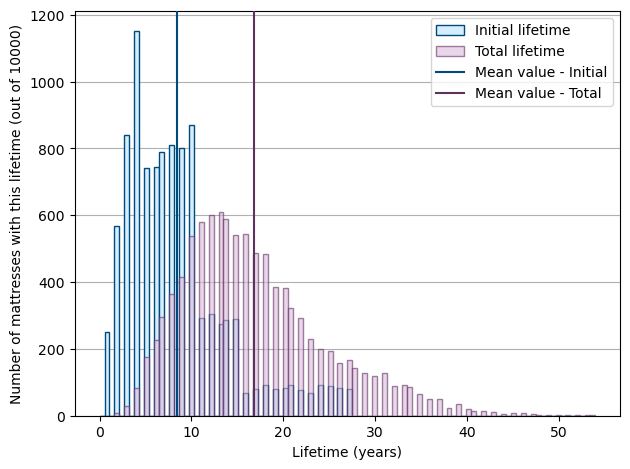

In [59]:
figure_lifetime_distribution(
    mattress_n_sample, 
    mattress_lifetime_list_possible_values,
    mattress_lifetime_sample,
    mattress_add_lifetime_sample,
    "mattresses"
)

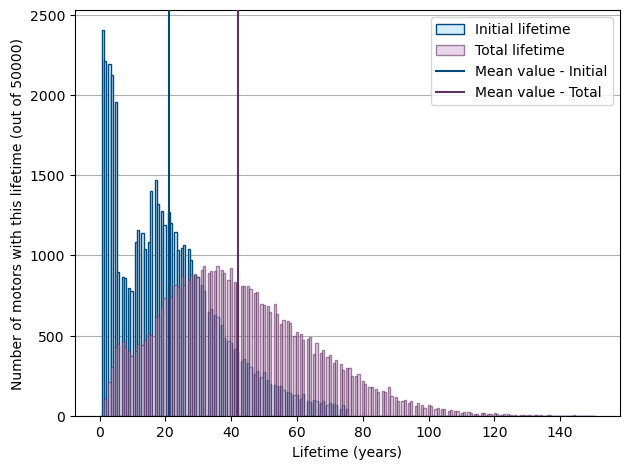

In [60]:
figure_lifetime_distribution(
    motor_n_sample, 
    motor_lifetime_list_possible_values,
    motor_lifetime_sample,
    motor_add_lifetime_sample,
    "motors"
)

### Figures in manuscript

In [61]:
def plot_distribution_absolute(ax, product_name, n_sample, lcia_sample_baseline, lcia_sample_repair, labels, format_label="{:.1f}", methods_label=methods_label, methods_unit=methods_unit):
    # Data to plot
    num_bins = math.ceil(math.sqrt(n_sample)) # Decide on the number of bars
    combined_data = np.concatenate((lcia_sample_baseline, lcia_sample_repair))
    data_min = np.min(combined_data)
    data_max = np.max(combined_data)
    bin_width = (data_max - data_min) / num_bins
    edge_bins = np.arange(data_min, data_max + bin_width, bin_width)
    
    # Plot data
    ax.hist(
        lcia_sample_baseline, # Values
        bins=edge_bins, # Number of bars
        label=labels[0], # Label for the legend
        color="#D4EEFF", alpha=1, edgecolor="#004A7B", # Colors
        zorder=10 # Move forward in the order of layers on the figure (behind girdlines)
    )
    ax.hist(
        lcia_sample_repair, # Values
        bins=edge_bins, # Number of bars
        label=labels[1], # Label for the legend
        color="#DCBBDC", alpha=0.6, edgecolor="#5F315F", # Colors
        zorder=10 # Move forward in the order of layers on the figure (behind girdlines)
    )
    
    # Mean values
    ax.axvline(x=np.mean(lcia_sample_baseline), color="#004A7B", label="Mean value - " + labels[2] + " (" + format_label.format(np.mean(lcia_sample_baseline)) + " " + methods_unit + ")", zorder=15)
    ax.axvline(x=np.mean(lcia_sample_repair), color="#5F315F", label="Mean value - " + labels[3] + " (" + format_label.format(np.mean(lcia_sample_repair)) + " " + methods_unit + ")", zorder=15)
        
    # Add title and labels
    ax.set_xlabel(methods_label + ' per year of use')
    ax.set_ylabel('Number of ' + product_name + ' (out of ' + str(n_sample)+ ')')
        
    # Turn on gridlines
    ax.grid(axis='y', zorder=0)

    # Add legend
    ax.legend()

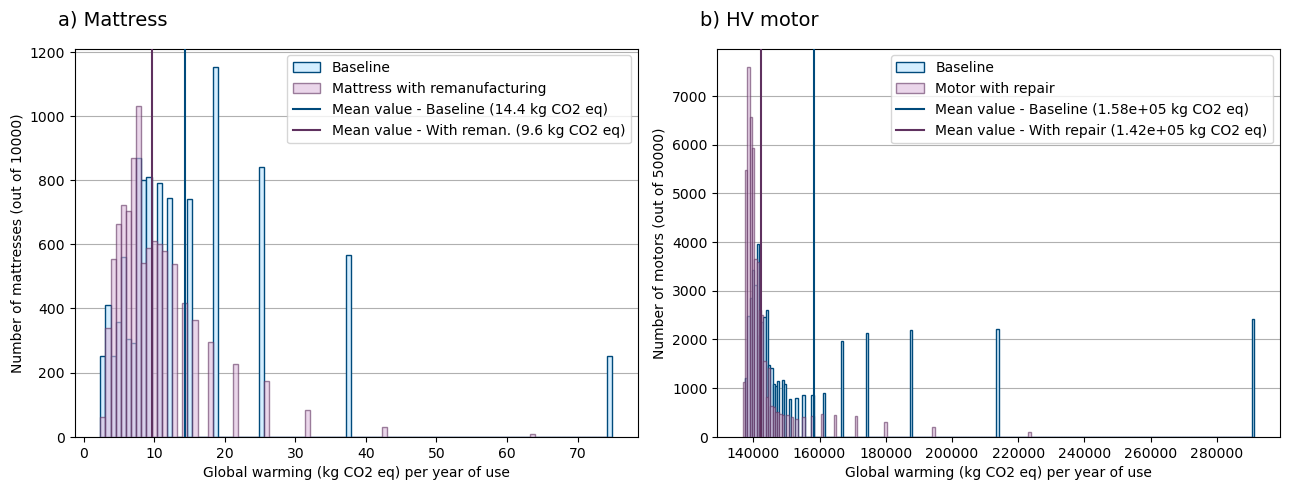

In [62]:
# Generate the figure and axis objects
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(13,5))

# Mattress
plot_distribution_absolute(
    ax[0],
    product_name = "mattresses",
    n_sample = mattress_n_sample,
    lcia_sample_baseline = mattress_lcia_sample_baseline,
    lcia_sample_repair = mattress_lcia_sample_refurbish,
    labels = ["Baseline", "Mattress with remanufacturing", "Baseline", "With reman."]
)

# Motor
plot_distribution_absolute(
    ax[1],
    product_name = "motors",
    n_sample = motor_n_sample,
    lcia_sample_baseline = motor_lcia_sample_baseline,
    lcia_sample_repair = motor_lcia_sample_repair,
    labels = ["Baseline", "Motor with repair", "Baseline", "With repair"],
    format_label="{:.2e}"
)

# Sub-titles
for n, text in enumerate(["a) Mattress", "b) HV motor"]):
    ax[n].annotate(text, xy=(-0.03, 1.1), xycoords='axes fraction', fontsize=14, ha='left', va='top')
    
# Remove white margins
fig.tight_layout()
    
# Save the plot
fig.savefig("figures\\article_" + methods_code + "_distribution_absolute.svg")
    
# Show the plot
plt.show()

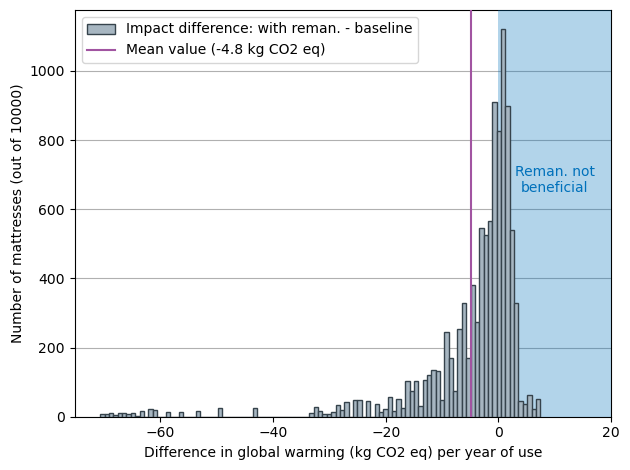

In [64]:
# Generate the figure and axis objects
fig, ax = plt.subplots()
    
# Prepare data
mattress_lcia_sample_relative = [mattress_lcia_sample_refurbish[i] - mattress_lcia_sample_baseline[i] for i in range(mattress_n_sample)]
    
# Determine the number of bins
num_bins = math.ceil(math.sqrt(mattress_n_sample))
    
# Determine the bin edges for it to be centered on 0
data_min = np.min(mattress_lcia_sample_relative)
data_max = np.max(mattress_lcia_sample_relative)
bin_width = (data_max - data_min) / num_bins
bin_edges = np.arange(data_min - bin_width / 2, data_max + bin_width, bin_width)
    
# Figure
ax.hist(
    mattress_lcia_sample_relative, # Values
    bins=bin_edges, # Number of bars
    label="Impact difference: with reman. - baseline", # Label for the legend
    color="#A7B6C1", edgecolor="#36434C", # Colors
    zorder=10 # Move forward in the order of layers on the figure (behind girdlines)
)

# Mean values
ax.axvline(x=np.mean(mattress_lcia_sample_relative), color="#A154A1", label="Mean value (" + "{:.1f}".format(np.mean(mattress_lcia_sample_relative)) + " " + methods_unit + ")", zorder=15)

# Clearer explanation of results
ax.axvspan(0, 20, facecolor='#0071BB', alpha=0.3, zorder=5)
ax.text(10, 650, 'Reman. not\nbeneficial', horizontalalignment='center', color='#0071BB')
ax.set_xlim(right=20)

# Add legend
plt.legend()
    
# Add labels
ax.set_xlabel('Difference in ' + methods_label[0].lower() + methods_label[1:] + ' per year of use')
ax.set_ylabel('Number of mattresses (out of ' + str(mattress_n_sample)+ ')')
    
# Turn on gridlines
ax.grid(axis='y', zorder=0)
    
# Remove white margins
plt.tight_layout()
    
# Save the plot
fig.savefig("figures\\article_" + methods_code + "_" + "mattresses" + "_distribution_relative.svg")
    
# Show the plot
plt.show()

### Figures in SI

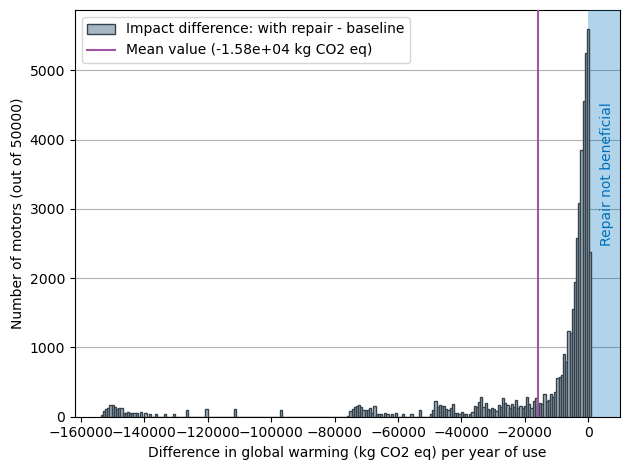

In [65]:
# Generate the figure and axis objects
fig, ax = plt.subplots()
    
# Prepare data
motor_lcia_sample_relative = [motor_lcia_sample_repair[i] - motor_lcia_sample_baseline[i] for i in range(motor_n_sample)]
    
# Determine the number of bins
num_bins = math.ceil(math.sqrt(motor_n_sample))
    
# Determine the bin edges for it to be centered on 0
data_min = np.min(motor_lcia_sample_relative)
data_max = np.max(motor_lcia_sample_relative)
bin_width = (data_max - data_min) / num_bins
bin_edges = np.arange(data_min - bin_width / 2, data_max + bin_width, bin_width)
    
# Figure
ax.hist(
    motor_lcia_sample_relative, # Values
    bins=bin_edges, # Number of bars
    label="Impact difference: with repair - baseline", # Label for the legend
    color="#A7B6C1", edgecolor="#36434C", # Colors
    zorder=10 # Move forward in the order of layers on the figure (behind girdlines)
)

# Mean values
ax.axvline(x=np.mean(motor_lcia_sample_relative), color="#A154A1", label="Mean value (" + "{:.2e}".format(np.mean(motor_lcia_sample_relative)) + " " + methods_unit + ")", zorder=15)

# Clearer explanation of results
ax.axvspan(0, 10000, facecolor='#0071BB', alpha=0.3, zorder=5)
ax.text(6000, 2500, 'Repair not beneficial', horizontalalignment='center', color='#0071BB', rotation=90)
ax.set_xlim(right=10000)

# Add legend
plt.legend()
    
# Add labels
ax.set_xlabel('Difference in ' + methods_label[0].lower() + methods_label[1:] + ' per year of use')
ax.set_ylabel('Number of ' + "motors" + ' (out of ' + str(motor_n_sample)+ ')')
    
# Turn on gridlines
ax.grid(axis='y', zorder=0)
    
# Remove white margins
plt.tight_layout()
    
# Save the plot
fig.savefig("figures\\article_si_" + methods_code + "_" + "motor" + "_distribution_relative.svg")
    
# Show the plot
plt.show()

### Generation of results tables for the SI

Table of results for the mattress:

In [67]:
pd.DataFrame(
    {'initial lifetime': mattress_lifetime_sample,
    'additional lifetime': mattress_add_lifetime_sample,
    'baseline (' + str(methods_unit) + ')': mattress_lcia_sample_baseline,
    'remanufacturing (' + str(methods_unit) + ')': mattress_lcia_sample_refurbish}
).to_excel('tables/distribution_results_mattress.xlsx', index=False)

Table of results for the HV motor:

In [68]:
pd.DataFrame(
    {'initial lifetime': motor_lifetime_sample,
    'additional lifetime': motor_add_lifetime_sample,
    'baseline (' + str(methods_unit) + ')': motor_lcia_sample_baseline,
    'repair (' + str(methods_unit) + ')': motor_lcia_sample_repair}
).to_excel('tables/distribution_results_motor.xlsx', index=False)

# Figures for other impact categories in SI

## Functions to generate the plots

In [69]:
def article_si_figure_other_cat_single(ax, product_name, lifetime_list, df_production, df_eol, df_repair, df_use=None, methods_label=methods_label):
    # Figure colors
    figure_colors = {
        "production": "#004A7B",
        "end-of-life treatment": "#28A9FF",
        "remanufacturing": "#A154A1",
        "repair": "#A154A1",
        "use": "gray"
    }
    
    # Parameters for the figures
    width_bar = 0.8 #width of the bars, should be <1
    
    # List of data to plot
    scenario_list = []
    for lifetime in lifetime_list:
        scenario_list.append((lifetime,))
        for add_lifetime in lifetime_list:
            scenario_list.append((lifetime, add_lifetime))

    if product_name == "mattress":
        data_to_plot, x_axis_legend, x_values = mattress_article_figure_data_to_plot(scenario_list, df_production=df_production, df_eol=df_eol, df_repair=df_repair)
    elif product_name == "motor":
        data_to_plot, x_axis_legend, x_values = motor_article_figure_data_to_plot(scenario_list, df_production=df_production, df_eol=df_eol, df_repair=df_repair, df_use=df_use)
    
    # Figure
    for n_fig in range(2):
        for n_bar, data in enumerate(data_to_plot[n_fig]):
            for i, activity in enumerate(data.index):
                if n_bar == len(data_to_plot) - 1 and n_fig == 1:
                    ax[n_fig].bar(
                        x_values[n_bar], 
                        data.loc[activity, "impact"], 
                        bottom=data.iloc[:i,0].sum(), 
                        label=activity, 
                        color=figure_colors[activity], width=width_bar, edgecolor="black",
                        zorder=10
                    )
                else:
                    ax[n_fig].bar(
                        x_values[n_bar], 
                        data.loc[activity, "impact"], 
                        bottom=data.iloc[:i,0].sum(), 
                        color=figure_colors[activity], width=width_bar, edgecolor="black",
                        zorder=10
                    )
    
    # Add legend, title, and labels
    ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4)
    ax[0].set_ylabel(methods_label + '\nper product')
    ax[1].set_ylabel(methods_label + '\nper year of use')
    for n_fig in range(2):
        ax[n_fig].set_xticks(x_values, x_axis_legend, fontsize=9.5)
        ax[n_fig].ticklabel_format(style='scientific', axis='y', scilimits=(0, 4))
        # Turn on gridlines
        ax[n_fig].grid(axis="y", zorder=0)

In [70]:
def plot_parameter_figure(ax, product_name, repair_name, lcia_production, lcia_eol, lcia_repair, lcia_use=None, figure_lifetime_max=40, y_lim=25, x_ticks_space=2, y_ticks_space=2, methods_label=methods_label):
    
    # Data in common with all plots
    slope_breakeven = calculation_breakeven_value_factor(
        lcia_production, 
        lcia_eol, 
        lcia_repair
    )

    # Values for lines
    x_baseline = np.linspace(0.001, figure_lifetime_max, 1000)
    y_baseline = (lcia_production.loc[0, "score"] + lcia_eol.loc[0, "score"]) / x_baseline
    y_ce = (lcia_production.loc[0, "score"] + lcia_eol.loc[0, "score"] + lcia_repair.loc[0, "score"]) / x_baseline

    # Values for the contributions
    y_production = lcia_production.loc[0, "score"] / x_baseline
    if lcia_use is not None:
        y_use = lcia_use.loc[0, "score"]

    # Plot the lines
    if lcia_use is None:
        ax.plot(
            x_baseline, y_baseline,  # Values
            color="#004A7B",  # Color
            label="baseline", # Label for the lengend
            zorder=10  # Move forward in the order of layers on the figure (behind gridlines)
        )
        ax.plot(
            x_baseline, y_ce,  # Values
            color="#A154A1",  # Color
            label=product_name+ " with " + repair_name, # Label for the lengend
            zorder=10  # Move forward in the order of layers on the figure (behind gridlines)
        )
    else:
        ax.plot(
            x_baseline, y_baseline + y_use,  # Values
            color="#004A7B",  # Color
            label="baseline", # Label for the lengend
            zorder=10  # Move forward in the order of layers on the figure (behind gridlines)
        )
        ax.plot(
            x_baseline, y_ce + y_use,  # Values
            color="#A154A1",  # Color
            label=product_name+ " with " + repair_name, # Label for the lengend
            zorder=10  # Move forward in the order of layers on the figure (behind gridlines)
        )

    # Plot the contributions
    if lcia_use is None:
        ax.fill_between(x_baseline, y_production, color="#004A7B", alpha=0.3, label="contribution from production")
        ax.fill_between(x_baseline, y_baseline, y_production, color="#28A9FF", alpha=0.3, label="contribution from end-of-life treatment")
        ax.fill_between(x_baseline, y_ce, y_baseline, color="#A154A1", alpha=0.3, label="contribution from " + repair_name)
    else:
        ax.fill_between(x_baseline, y_use, color="gray", alpha=0.3, label="contribution from use")
        ax.fill_between(x_baseline, y_production + y_use, y_use, color="#004A7B", alpha=0.3, label="contribution from production")
        ax.fill_between(x_baseline, y_baseline + y_use, y_production + y_use, color="#28A9FF", alpha=0.3, label="contribution from end-of-life treatment")
        ax.fill_between(x_baseline, y_ce + y_use, y_baseline + y_use, color="#A154A1", alpha=0.3, label="contribution from remanufacturing")

    # Add legend, title and labels
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3)
    ax.set_xlabel('Total (initial + additional) lifetime (years)')
    ax.set_ylabel(methods_label + '\nper year of use')

    # Change format of x-axis tick labels
    ax.xaxis.set_major_locator(ticker.MultipleLocator(x_ticks_space))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(y_ticks_space))
    ax.ticklabel_format(style='scientific', axis='both', scilimits=(0, 4))
    
    # Turn on gridlines
    ax.grid(axis='y', zorder=0)
    
    # Set the x-axis and y-axis limits to start at 0
    ax.set_xlim(left=0, right=figure_lifetime_max)
    ax.set_ylim(bottom=0, top=y_lim)

In [71]:
def plot_distribution_absolute(ax, product_name, n_sample, lcia_sample_baseline, lcia_sample_repair, labels, format_label="{:.1f}", methods_label=methods_label, methods_unit=methods_unit):
    # Data to plot
    num_bins = math.ceil(math.sqrt(n_sample)) # Decide on the number of bars
    combined_data = np.concatenate((lcia_sample_baseline, lcia_sample_repair))
    data_min = np.min(combined_data)
    data_max = np.max(combined_data)
    bin_width = (data_max - data_min) / num_bins
    edge_bins = np.arange(data_min, data_max + bin_width, bin_width)
    
    # Plot data
    ax.hist(
        lcia_sample_baseline, # Values
        bins=edge_bins, # Number of bars
        label=labels[0], # Label for the legend
        color="#D4EEFF", alpha=1, edgecolor="#004A7B", # Colors
        zorder=10 # Move forward in the order of layers on the figure (behind girdlines)
    )
    ax.hist(
        lcia_sample_repair, # Values
        bins=edge_bins, # Number of bars
        label=labels[1], # Label for the legend
        color="#DCBBDC", alpha=0.6, edgecolor="#5F315F", # Colors
        zorder=10 # Move forward in the order of layers on the figure (behind girdlines)
    )
    
    # Mean values
    ax.axvline(x=np.mean(lcia_sample_baseline), color="#004A7B", label="Mean value - " + labels[2] + "\n(" + format_label.format(np.mean(lcia_sample_baseline)) + " " + methods_unit + ")", zorder=15)
    ax.axvline(x=np.mean(lcia_sample_repair), color="#5F315F", label="Mean value - " + labels[3] + "\n(" + format_label.format(np.mean(lcia_sample_repair)) + " " + methods_unit + ")", zorder=15)
        
    # Add title and labels
    ax.set_xlabel(methods_label + '\nper year of use', labelpad=10)
    ax.set_ylabel('Number of ' + product_name + ' (out of ' + str(n_sample)+ ')')
    ax.ticklabel_format(style='scientific', axis='both', scilimits=(0, 4))
        
    # Turn on gridlines
    ax.grid(axis='y', zorder=0)

    # Add legend
    ax.legend()

In [72]:
def article_si_figure_distrib_relative(ax, product_name, n_sample, lcia_sample_baseline, lcia_sample_repair, labels, x_lim, format_label="{:.1f}", methods_label=methods_label, methods_unit=methods_unit):
 
    # Prepare data
    lcia_sample_relative = [lcia_sample_repair[i] - lcia_sample_baseline[i] for i in range(n_sample)]
    
    # Determine the number of bins
    num_bins = math.ceil(math.sqrt(n_sample))
    
    # Determine the bin edges for it to be centered on 0
    data_min = np.min(lcia_sample_relative)
    data_max = np.max(lcia_sample_relative)
    bin_width = (data_max - data_min) / num_bins
    bin_edges = np.arange(data_min - bin_width / 2, data_max + bin_width, bin_width)
    
    # Figure
    ax.hist(
        lcia_sample_relative, # Values
        bins=bin_edges, # Number of bars
        label="Impact difference: with " + labels[0] + " - baseline", # Label for the legend
        color="#A7B6C1", edgecolor="#36434C", # Colors
        zorder=10 # Move forward in the order of layers on the figure (behind girdlines)
    )

    # Mean values
    ax.axvline(x=np.mean(lcia_sample_relative), color="#A154A1", label="Mean value\n(" + format_label.format(np.mean(lcia_sample_relative)) + " " + methods_unit + ")", zorder=15)

    # Clearer explanation of results
    ax.axvspan(0, x_lim, facecolor='#0071BB', alpha=0.3, zorder=5)
    #ax.text(10, 650, labels[0] + ' not\nbeneficial', horizontalalignment='center', color='#0071BB')
    #ax.text(6000, 2500, labels[0] + ' not beneficial', horizontalalignment='center', color='#0071BB', rotation=90)
    ax.text(x_lim/2, ax.get_ylim()[1]/2, labels[0] + ' not beneficial', ha='center', va='center', color='#0071BB', rotation=90)
    ax.set_xlim(right=x_lim)

    # Add legend
    ax.legend()
    
    # Add labels
    ax.set_xlabel('Difference in ' + methods_label[0].lower() + methods_label[1:] + '\nper year of use', labelpad=10)
    ax.set_ylabel('Number of ' + product_name + ' (out of ' + str(n_sample)+ ')')
    ax.ticklabel_format(style='scientific', axis='both', scilimits=(0, 4))
    
    # Turn on gridlines
    ax.grid(axis='y', zorder=0)

## Function to generate the figure

In [73]:
def article_si_figure_other_cat(product_name, repair_name, lifetime_list, lcia_production, lcia_eol, lcia_repair, n_sample, lcia_sample_baseline, lcia_sample_repair, labels_distrib, labels_relat, figure_lifetime_max, y_lim, x_lim, x_ticks_space, y_ticks_space, lcia_use=None, format_label="{:.1f}", methods_code=methods_code, methods_label=methods_label, methods_unit=methods_unit):
    # Set figure size
    ax = plt.figure(layout="constrained", figsize=(12,18)).subplot_mosaic(
        """
        AA
        BB
        CC
        DE
        """
    )
    
    # Single value
    article_si_figure_other_cat_single(
        ax=[ax["A"], ax["B"]],
        product_name=product_name,
        lifetime_list=lifetime_list,
        df_production=lcia_production, 
        df_eol=lcia_eol, 
        df_repair=lcia_repair, 
        df_use=lcia_use,
        methods_label=methods_label
    )

    # No fixed value
    plot_parameter_figure(
        ax["C"], 
        product_name=product_name, 
        repair_name=repair_name, 
        lcia_production=lcia_production, 
        lcia_eol=lcia_eol, 
        lcia_repair=lcia_repair, 
        figure_lifetime_max=figure_lifetime_max, 
        y_lim=y_lim,
        x_ticks_space=x_ticks_space,
        y_ticks_space=y_ticks_space,
        lcia_use=lcia_use,
        methods_label=methods_label
    )
    
    # Distribution
    if product_name == "mattress":
        distrib_product_name = "mattresses"
    else:
        distrib_product_name = "motors"
        
    plot_distribution_absolute(
        ax["D"],
        product_name = distrib_product_name,
        n_sample = n_sample,
        lcia_sample_baseline = lcia_sample_baseline,
        lcia_sample_repair = lcia_sample_repair,
        labels = labels_distrib,
        format_label=format_label,
        methods_label=methods_label,
        methods_unit=methods_unit
    )

    article_si_figure_distrib_relative(
        ax["E"],
        product_name = distrib_product_name,
        n_sample = n_sample,
        lcia_sample_baseline = lcia_sample_baseline,
        lcia_sample_repair = lcia_sample_repair,
        labels = labels_relat,
        x_lim=x_lim,
        format_label=format_label,
        methods_label=methods_label,
        methods_unit=methods_unit
    )

    # Titles and tick labels
    for n_plot in ["A", "B", "C", "D", "E"]:
        ax[n_plot].annotate(n_plot.lower() + ")", xy=(-0.03, 1.1), xycoords='axes fraction', fontsize=14, ha='right', va='top')
        #ax[n_plot].ticklabel_format(style='scientific', axis='both', scilimits=(0, 4))
    
    # Save the plot
    plt.savefig("figures\\article_si_all_" + methods_code + "_" + product_name + ".svg", bbox_inches='tight')
    
    # Show the plot
    #return plt.show()

## Figures

In [74]:
#Information to generate the figures
list_methods = [
    ('EF v3.1', 'acidification', 'accumulated exceedance (AE)'),
    ('EF v3.1', 'energy resources: non-renewable', 'abiotic depletion potential (ADP): fossil fuels'),
    ('EF v3.1', 'material resources: metals/minerals', 'abiotic depletion potential (ADP): elements (ultimate reserves)'),
    ('EF v3.1', 'climate change', 'global warming potential (GWP100)'),
    ('EF v3.1', 'ecotoxicity: freshwater', 'comparative toxic unit for ecosystems (CTUe)'),
    ('EF v3.1', 'eutrophication: freshwater', 'fraction of nutrients reaching freshwater end compartment (P)'),
    ('EF v3.1', 'eutrophication: marine', 'fraction of nutrients reaching marine end compartment (N)'), 
    ('EF v3.1', 'eutrophication: terrestrial', 'accumulated exceedance (AE)'),
    ('EF v3.1', 'human toxicity: carcinogenic', 'comparative toxic unit for human (CTUh)'),
    ('EF v3.1', 'human toxicity: non-carcinogenic', 'comparative toxic unit for human (CTUh)'),
    ('EF v3.1', 'ionising radiation: human health', 'human exposure efficiency relative to u235'),
    ('EF v3.1', 'land use', 'soil quality index'),
    ('EF v3.1', 'ozone depletion', 'ozone depletion potential (ODP)'),
    ('EF v3.1', 'particulate matter formation', 'impact on human health'),
    ('EF v3.1', 'photochemical oxidant formation: human health', 'tropospheric ozone concentration increase'),
    ('EF v3.1', 'water use', 'user deprivation potential (deprivation-weighted water consumption)')
]
list_units = [bd.methods.get(method)["unit"] for method in list_methods]
list_methods_labels = [
    "Acidification",
    "Abiotic depletion - fossil fuels",
    "Abiotic depletion - elements",
    "Global warming",
    "Ecotoxicity",
    "Eutrophication - freshwater",
    "Eutrophication - marine",
    "Eutrophication - terrestrial",
    "Human toxicity - carcinogenic",
    "Human toxicity - non-carcinogenic",
    "Ionising radiation",
    "Land use",
    "Ozone depletion",
    "Particulate matter formation",
    "Photochemical oxidant formation",
    "Water use"
]
list_methods_labels = [label + " (" + list_units[i] + ")" for i,label in enumerate(list_methods_labels)]
list_methods_code = [
    "ap",
    "adpf",
    "adp",
    "gw",
    "ecot",
    "epf",
    "epm",
    "ept",
    "htpc",
    "htpn",
    "ir",
    "land",
    "odp",
    "pmf",
    "pof",
    "water"
]

Function to generate the figures for multiple impact categories.

In [77]:
def article_si_all_figures_other_cat(list_methods, list_methods_labels, list_methods_code, list_units):
    # Parameters for the figures
    list_lifetime_max_mattress = [
        40, 40, 40, 40, 40, 
        40, 40, 40, 40, 40,
        40, 40, 40, 40, 40, 40
    ]
    list_x_ticks_mattress = [
        2, 2, 2, 2, 2,
        2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2
    ]
    list_y_lim_mattress = [
        0.4, 300, 1.4E-4, 25, 450, 
        7E-3, 7E-2, 3E-1, 5E-8, 4E-7,
        3, 120, 6E-7, 3E-6, 1E-1, 100
    ]
    list_y_ticks_mattress = [
        0.05, 50, 2E-5, 2, 25, 
        5E-4, 5E-3, 2.5E-2, 5E-9, 5E-8,
        0.25, 10, 5E-8, 2.5E-7, 1E-2, 10
    ]
    list_x_lim_mattress = [
        0.1, 200, 1E-4, 20, 300, 
        5E-3, 5E-2, 0.25, 3E-8, 2E-7,
        1.75, 75, 3E-7, 1.5E-6, 5E-2, 50
    ]
    list_format_label_mattress = [
        "{:.2e}", "{:.2e}", "{:.2e}", "{:.1f}", "{:.1f}", 
        "{:.2e}", "{:.2e}", "{:.2f}", "{:.2e}", "{:.2e}",
        "{:.2f}", "{:.1f}", "{:.2e}", "{:.2e}", "{:.2e}", "{:.1f}"
    ]
    list_lifetime_max_motor = [
        50, 50, 50, 50, 50,
        50, 50, 50, 50, 50,
        50, 50, 50, 50, 50, 50
    ]
    list_x_ticks_motor = [
        5, 5, 5, 5, 5,
        5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5
    ]
    list_y_lim_motor = [
        1500, 2.3E7, 30, 2E5, 3E6,
        250, 500, 4000, 2E-3, 3E-2,
        1.7E6, 7E6, 7E-3, 3E-2, 1200, 1E6
    ]
    list_y_ticks_motor = [
        250, 2E6, 5, 2.5E4, 5E5,
        25, 50, 500, 2.5E-4, 5E-3,
        2.5E5, 5E5, 5E-4, 2.5E-3, 100, 1E5
    ]
    list_x_lim_motor = [
        500, 1E5, 5, 10000, 5E5, 
        25, 25, 250, 2E-4, 5E-3,
        0.5E4, 1E5, 2E-4, 2E-3, 100, 1E4
    ]
    list_format_label_motor = [
        "{:.2e}", "{:.2e}", "{:.2f}", "{:.2e}", "{:.2e}",
        "{:.1f}", "{:.1f}", "{:.2e}", "{:.2e}", "{:.2e}",
        "{:.2e}", "{:.2e}", "{:.2e}", "{:.2e}", "{:.1f}", "{:.2e}"
    ]
    
    for n_method, method in enumerate(list_methods):
        # LCA calculations
        lcia_mattress_production, lcia_mattress_eol, lcia_mattress_refurbish = lcia_calculations_product(
            act_mattress_production, 
            act_mattress_eol, 
            act_mattress_refurbish, 
            chosen_methods=[method]
        )
        lcia_im_motor_production, lcia_im_motor_eol, lcia_im_motor_repair, lcia_im_motor_use = lcia_calculations_product(
            act_im_motor_production, 
            act_im_motor_eol, 
            act_im_motor_repair, 
            act_use=act_im_motor_use, 
            chosen_methods=[method]
        )
        mattress_lcia_sample_baseline, mattress_lcia_sample_refurbish = lcia_samples_calculation(
            mattress_lifetime_sample,
            mattress_add_lifetime_sample,
            lcia_mattress_production,
            lcia_mattress_eol,
            lcia_mattress_refurbish
        )
        motor_lcia_sample_baseline, motor_lcia_sample_repair = lcia_samples_calculation(
            motor_lifetime_sample,
            motor_add_lifetime_sample,
            lcia_im_motor_production,
            lcia_im_motor_eol,
            lcia_im_motor_repair,
            lcia_use=lcia_im_motor_use
        )
        # Figures generation
        article_si_figure_other_cat(
            product_name="mattress",
            repair_name="remanufacturing",
            lifetime_list=[mattress_lifetime_value_min, mattress_lifetime_value_baseline, mattress_lifetime_value_max],
            lcia_production= lcia_mattress_production,
            lcia_eol=lcia_mattress_eol,
            lcia_repair=lcia_mattress_refurbish,
            n_sample = mattress_n_sample,
            lcia_sample_baseline = mattress_lcia_sample_baseline,
            lcia_sample_repair = mattress_lcia_sample_refurbish,
            labels_distrib = ["Baseline", "Mattress with remanufacturing", "Baseline", "With reman."],
            labels_relat = ["reman.", "Reman."],
            figure_lifetime_max=list_lifetime_max_mattress[n_method], 
            y_lim=list_y_lim_mattress[n_method],
            x_lim=list_x_lim_mattress[n_method],
            x_ticks_space=list_x_ticks_mattress[n_method],
            y_ticks_space=list_y_ticks_mattress[n_method],
            methods_code=list_methods_code[n_method], 
            methods_label=list_methods_labels[n_method],
            methods_unit=list_units[n_method],
            format_label=list_format_label_mattress[n_method]
        )
        article_si_figure_other_cat(
            product_name="motor",
            repair_name="repair",
            lifetime_list=[motor_lifetime_value_min, motor_lifetime_value_baseline, motor_lifetime_value_max],
            lcia_production= lcia_im_motor_production,
            lcia_eol=lcia_im_motor_eol,
            lcia_repair=lcia_im_motor_repair,
            n_sample = motor_n_sample,
            lcia_sample_baseline = motor_lcia_sample_baseline,
            lcia_sample_repair = motor_lcia_sample_repair,
            labels_distrib = ["Baseline", "Motor with repair", "Baseline", "With repair"],
            labels_relat = ["repair", "Repair"],
            figure_lifetime_max = list_lifetime_max_motor[n_method], 
            y_lim=list_y_lim_motor[n_method],
            x_lim=list_x_lim_motor[n_method],
            x_ticks_space=list_x_ticks_motor[n_method],
            y_ticks_space=list_y_ticks_motor[n_method],
            lcia_use=lcia_im_motor_use,
            methods_code=list_methods_code[n_method], 
            methods_label=list_methods_labels[n_method],
            methods_unit=list_units[n_method],
            format_label=list_format_label_motor[n_method]
        )


C:\Users\jeromea\AppData\Local\Temp\ipykernel_8780\3811695061.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  ax = plt.figure(layout="constrained", figsize=(12,18)).subplot_mosaic(


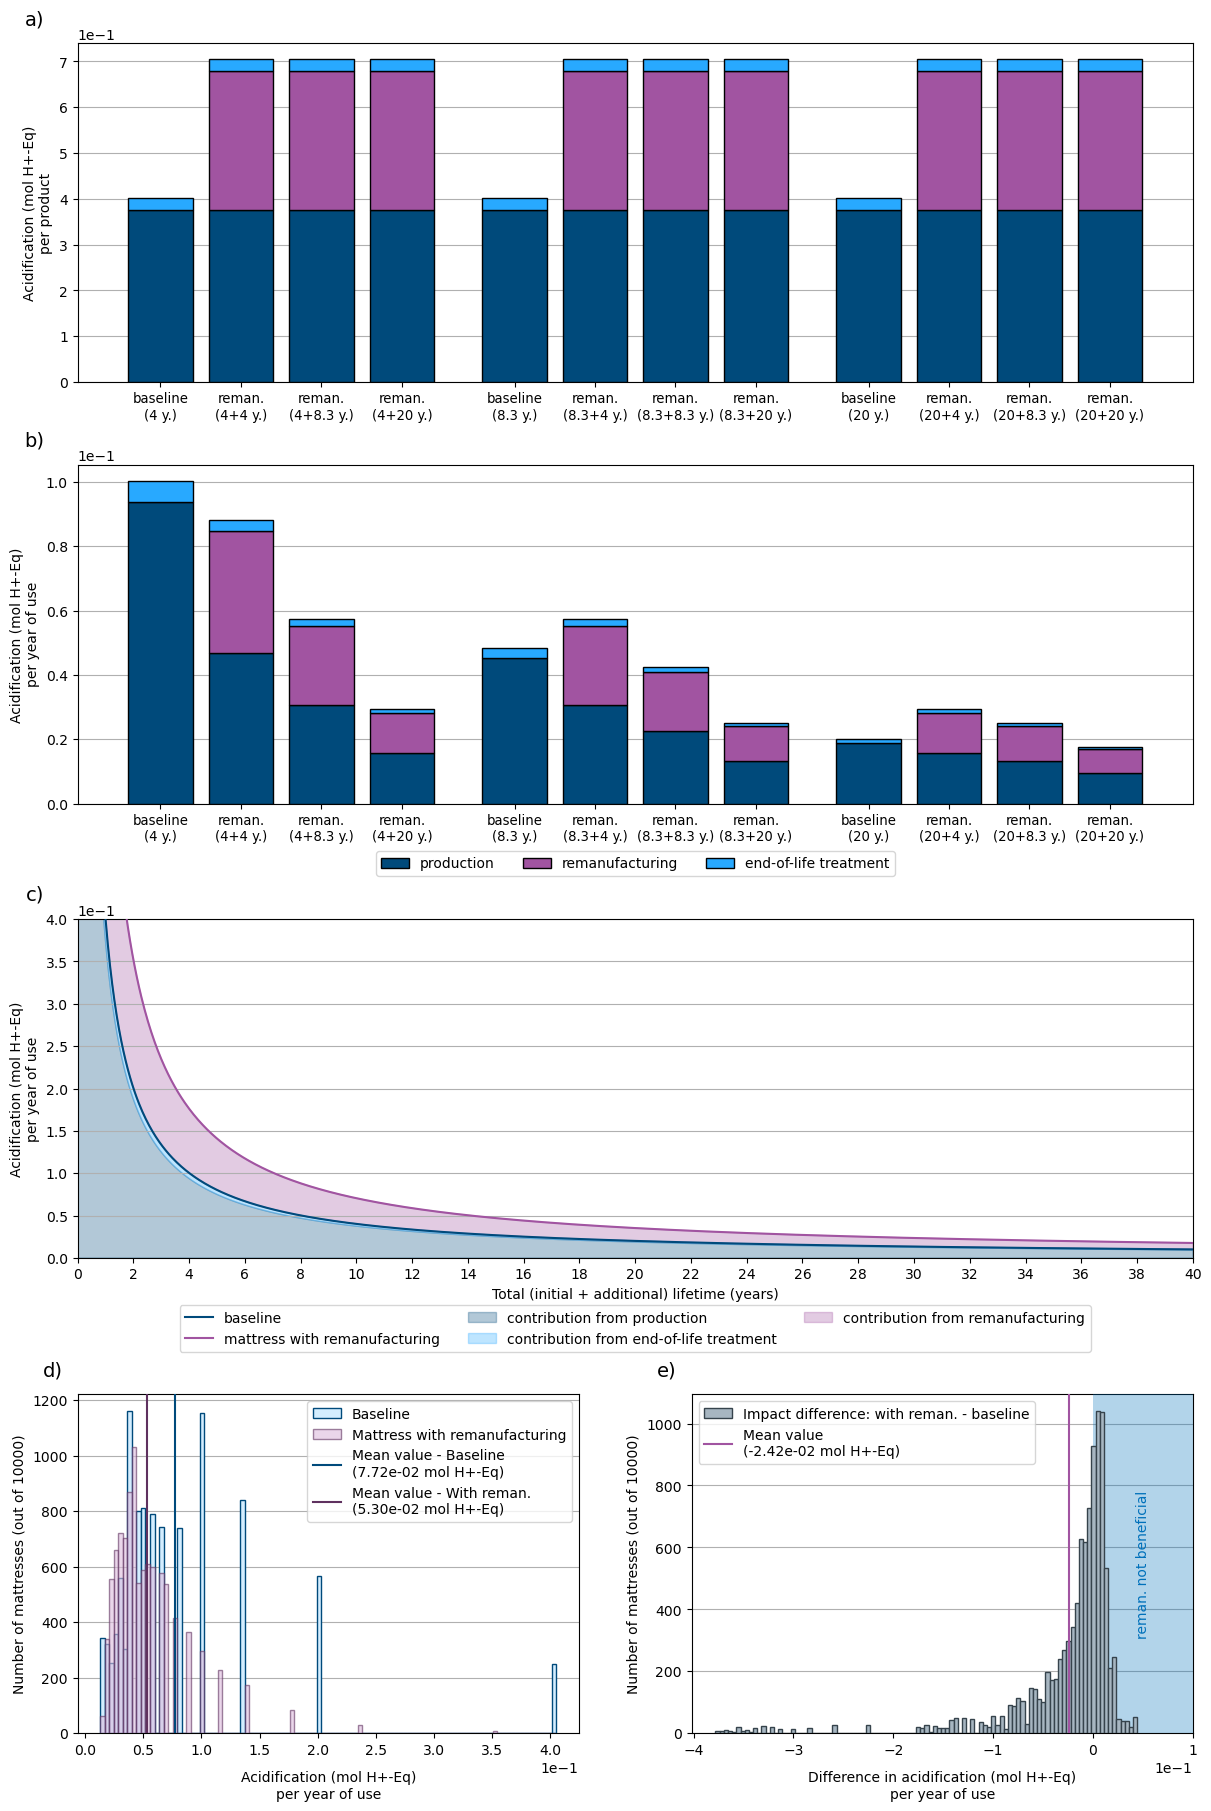

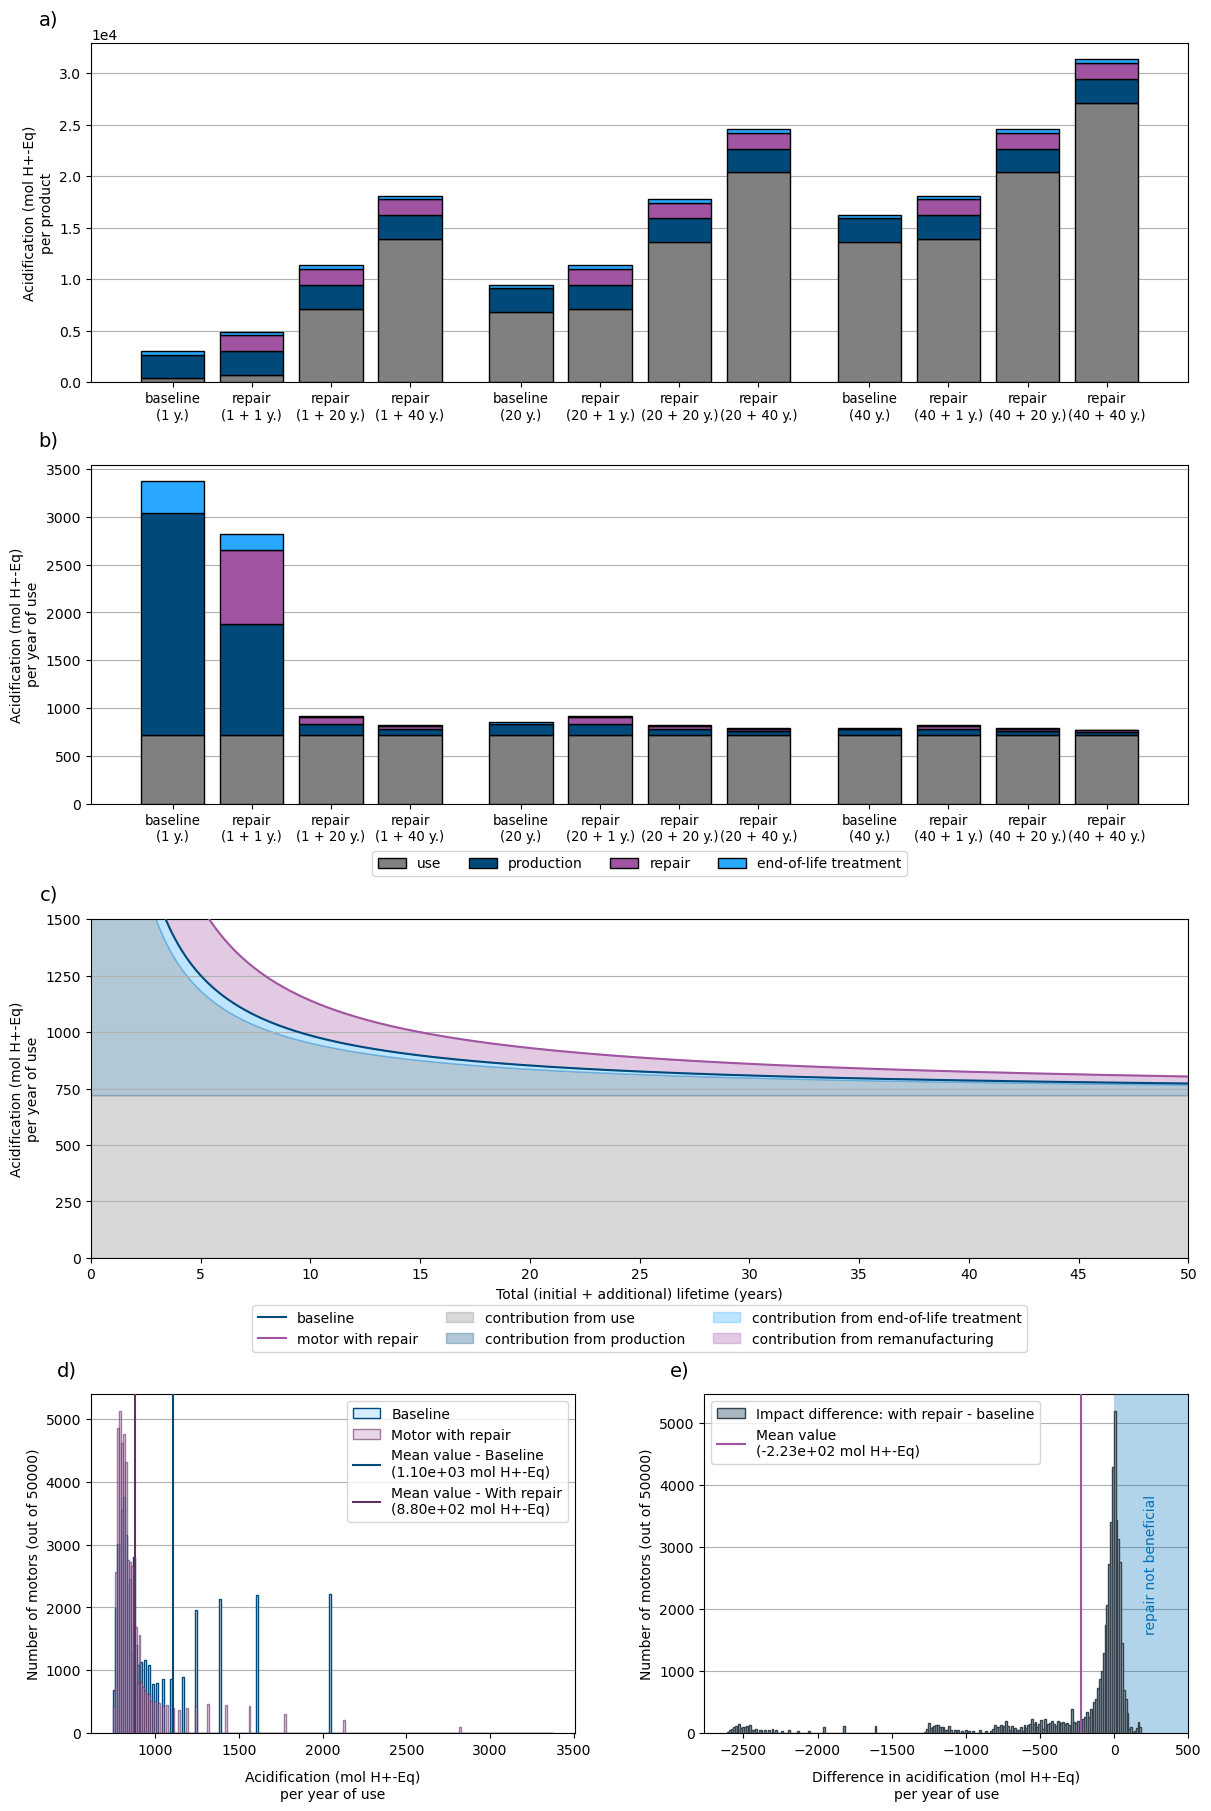

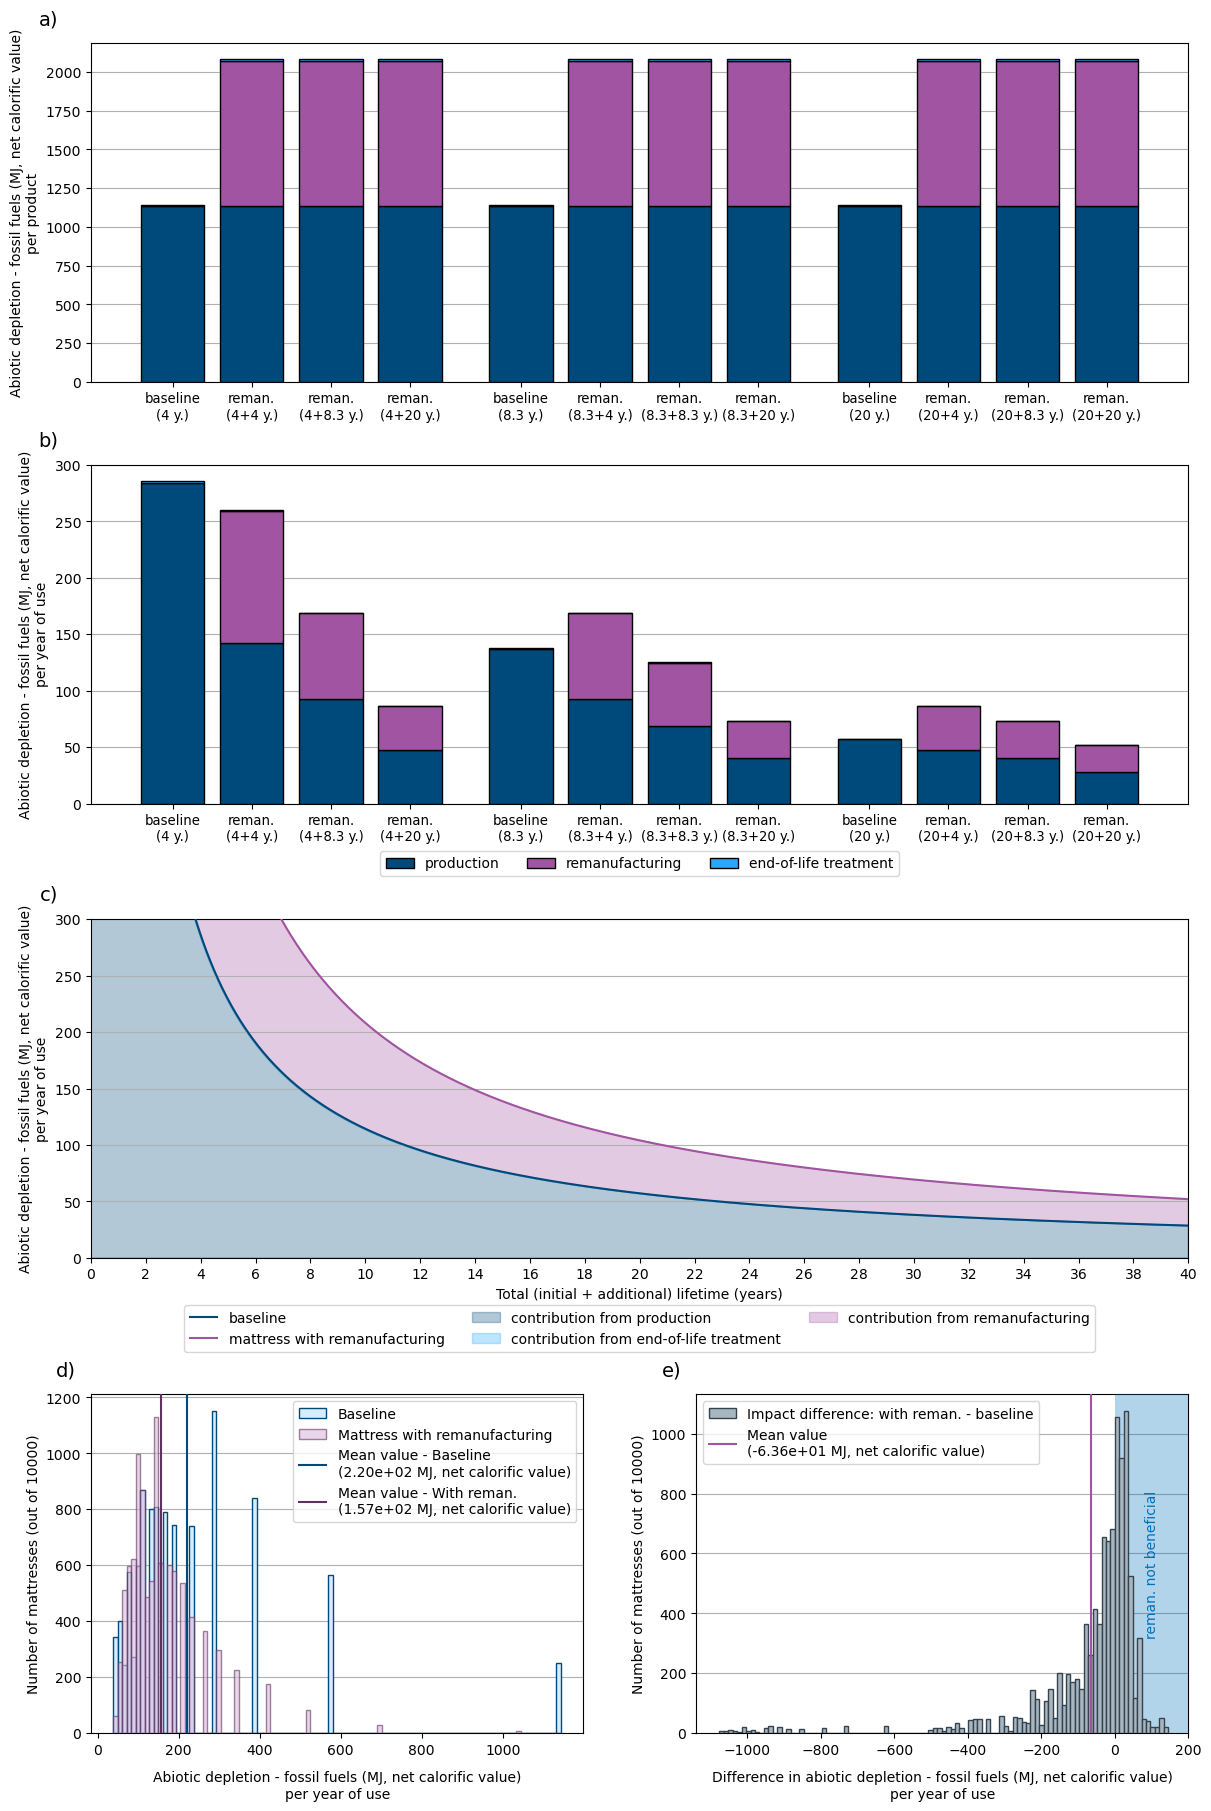

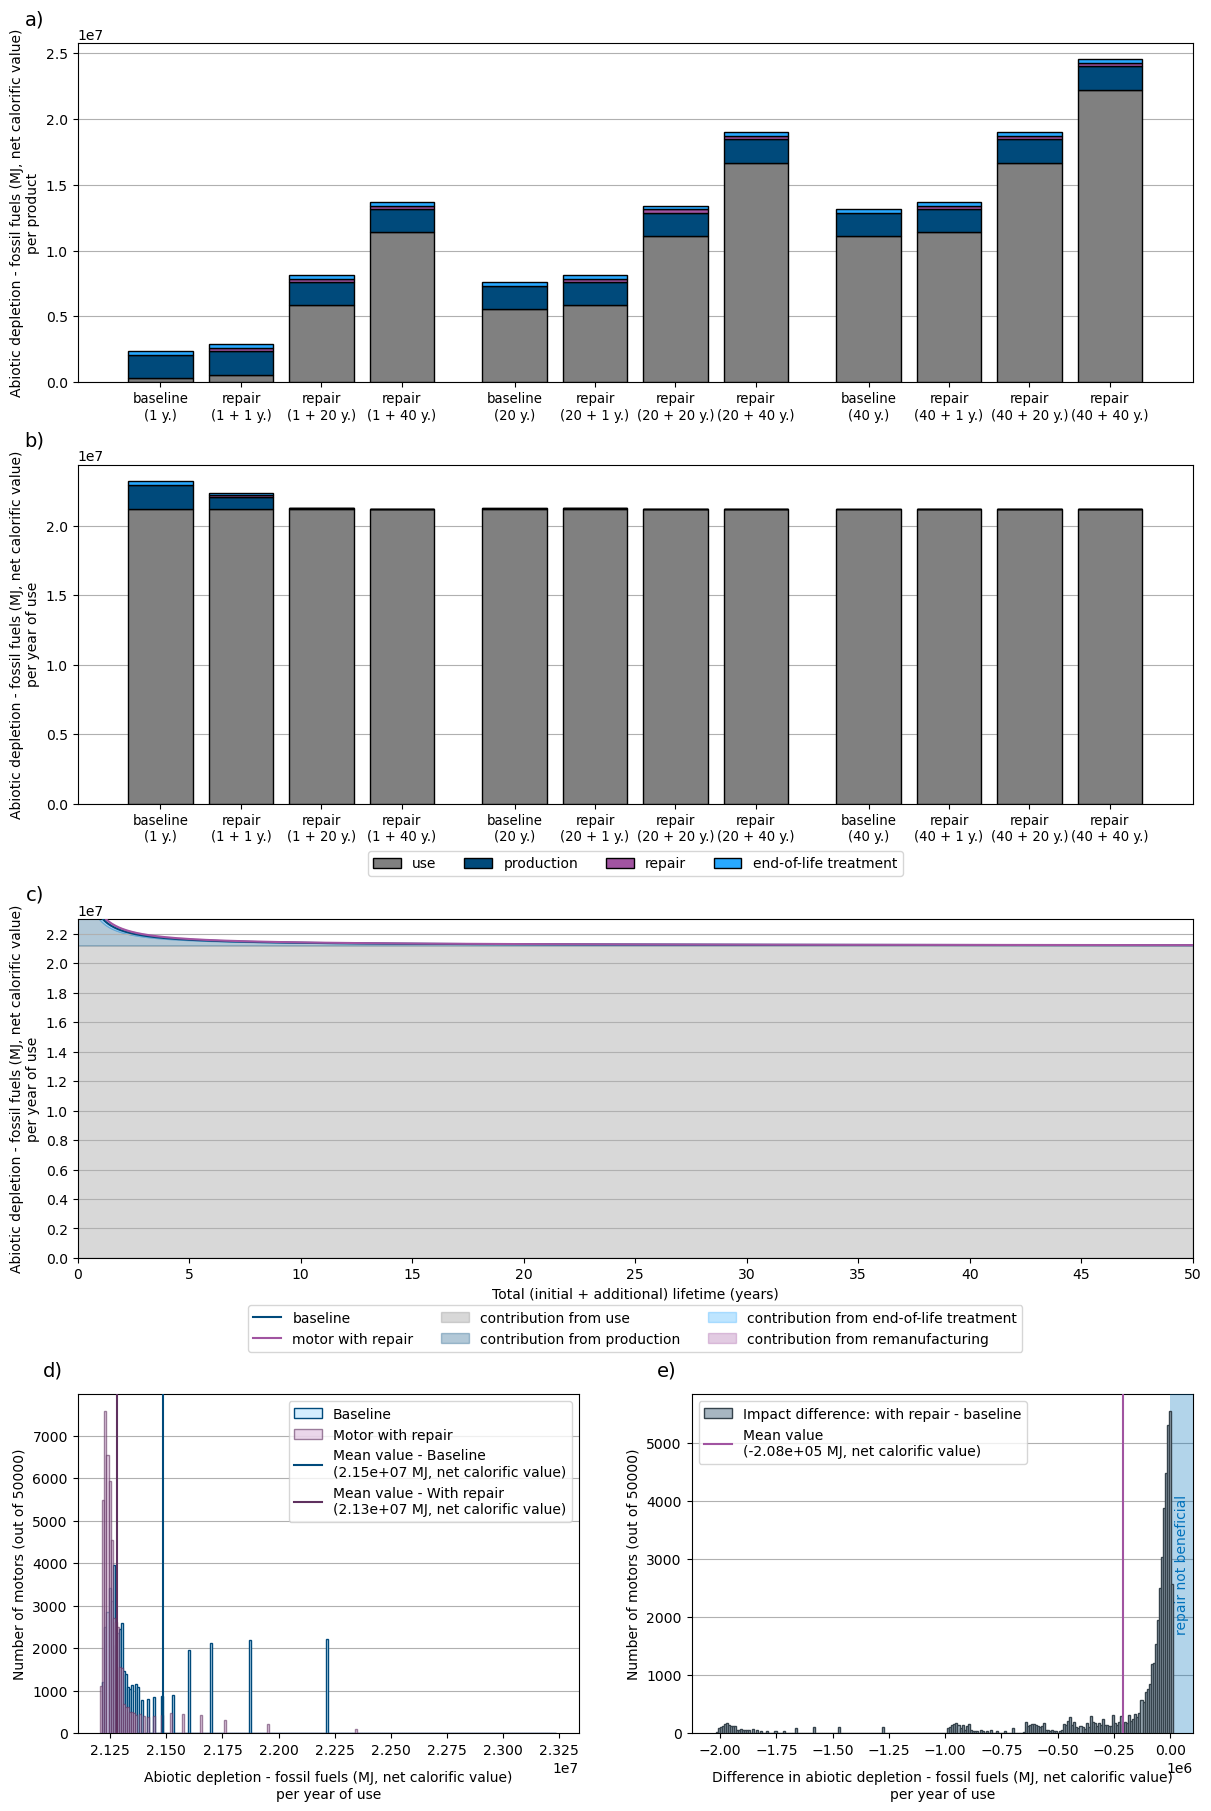

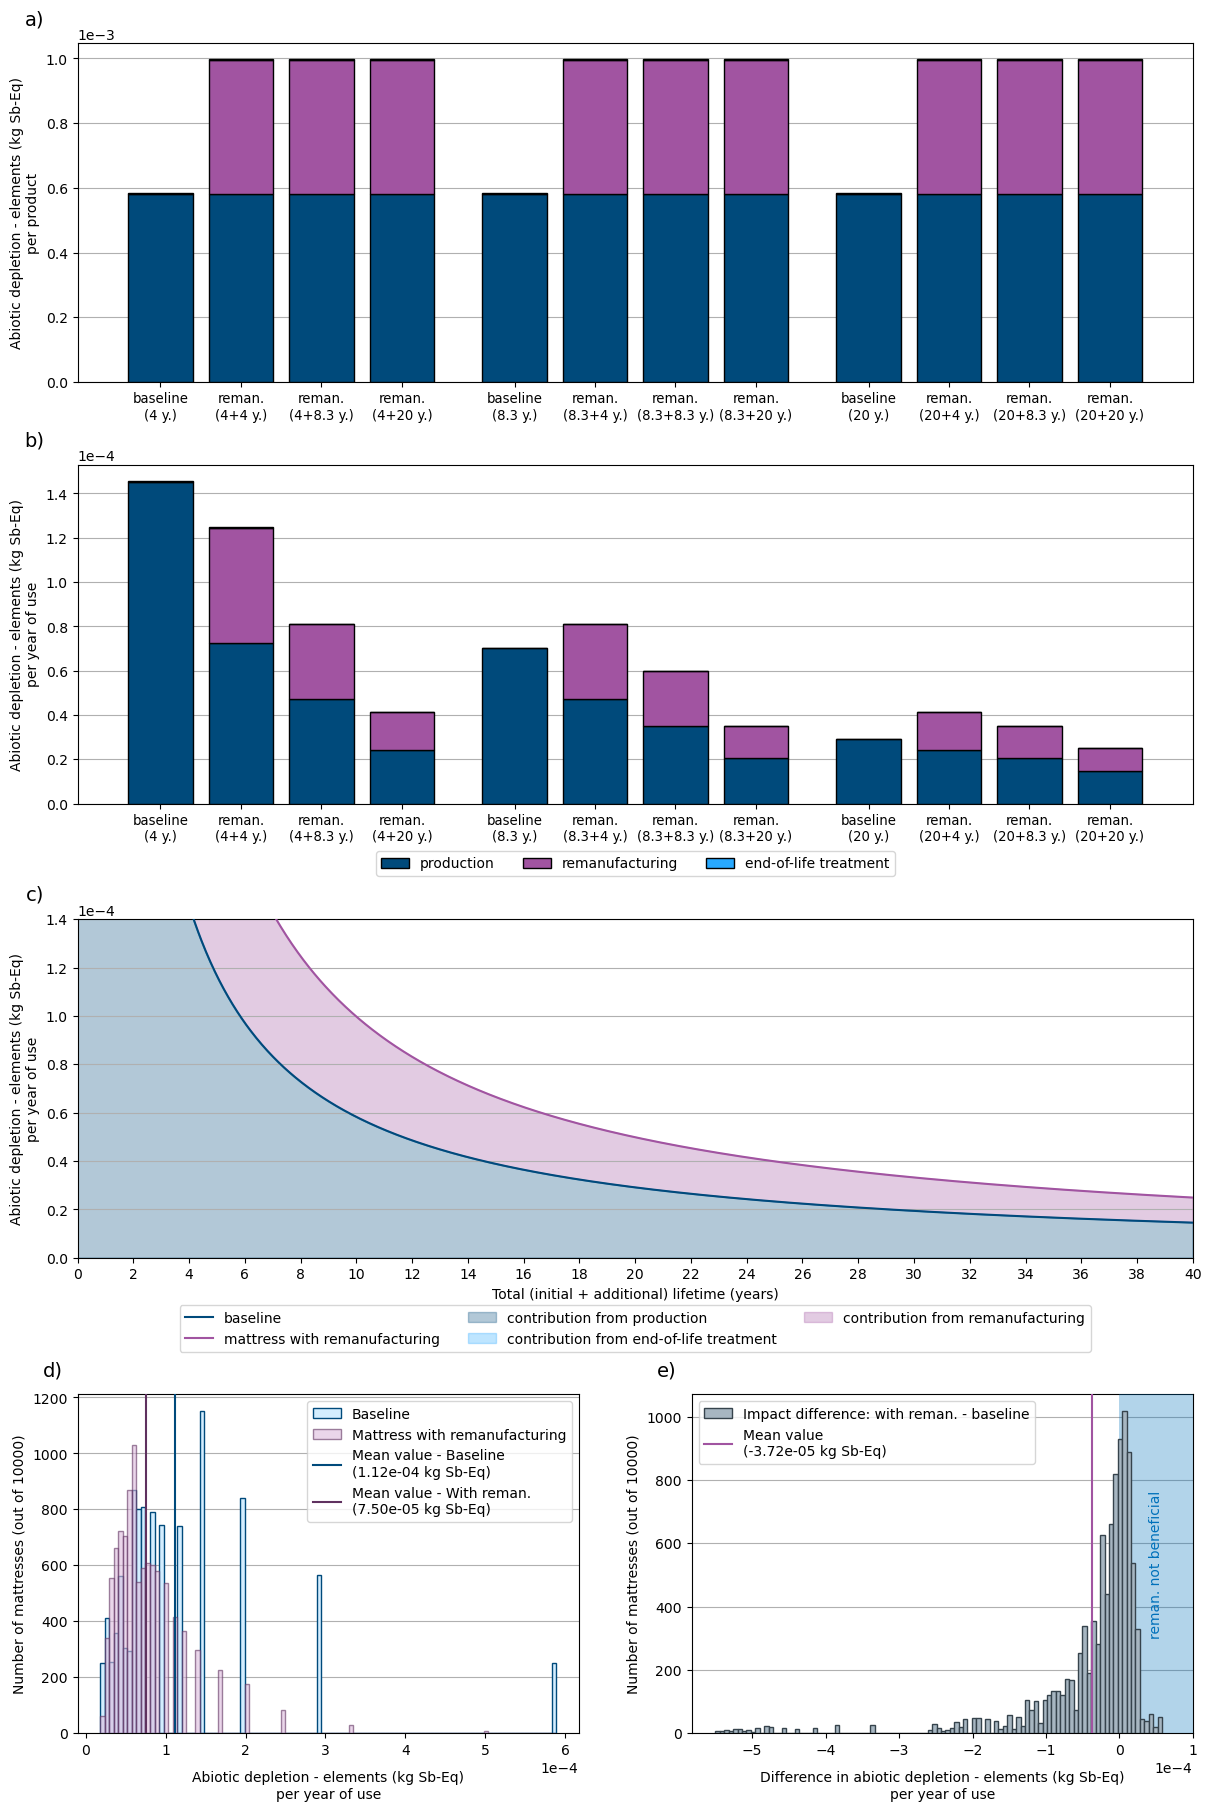

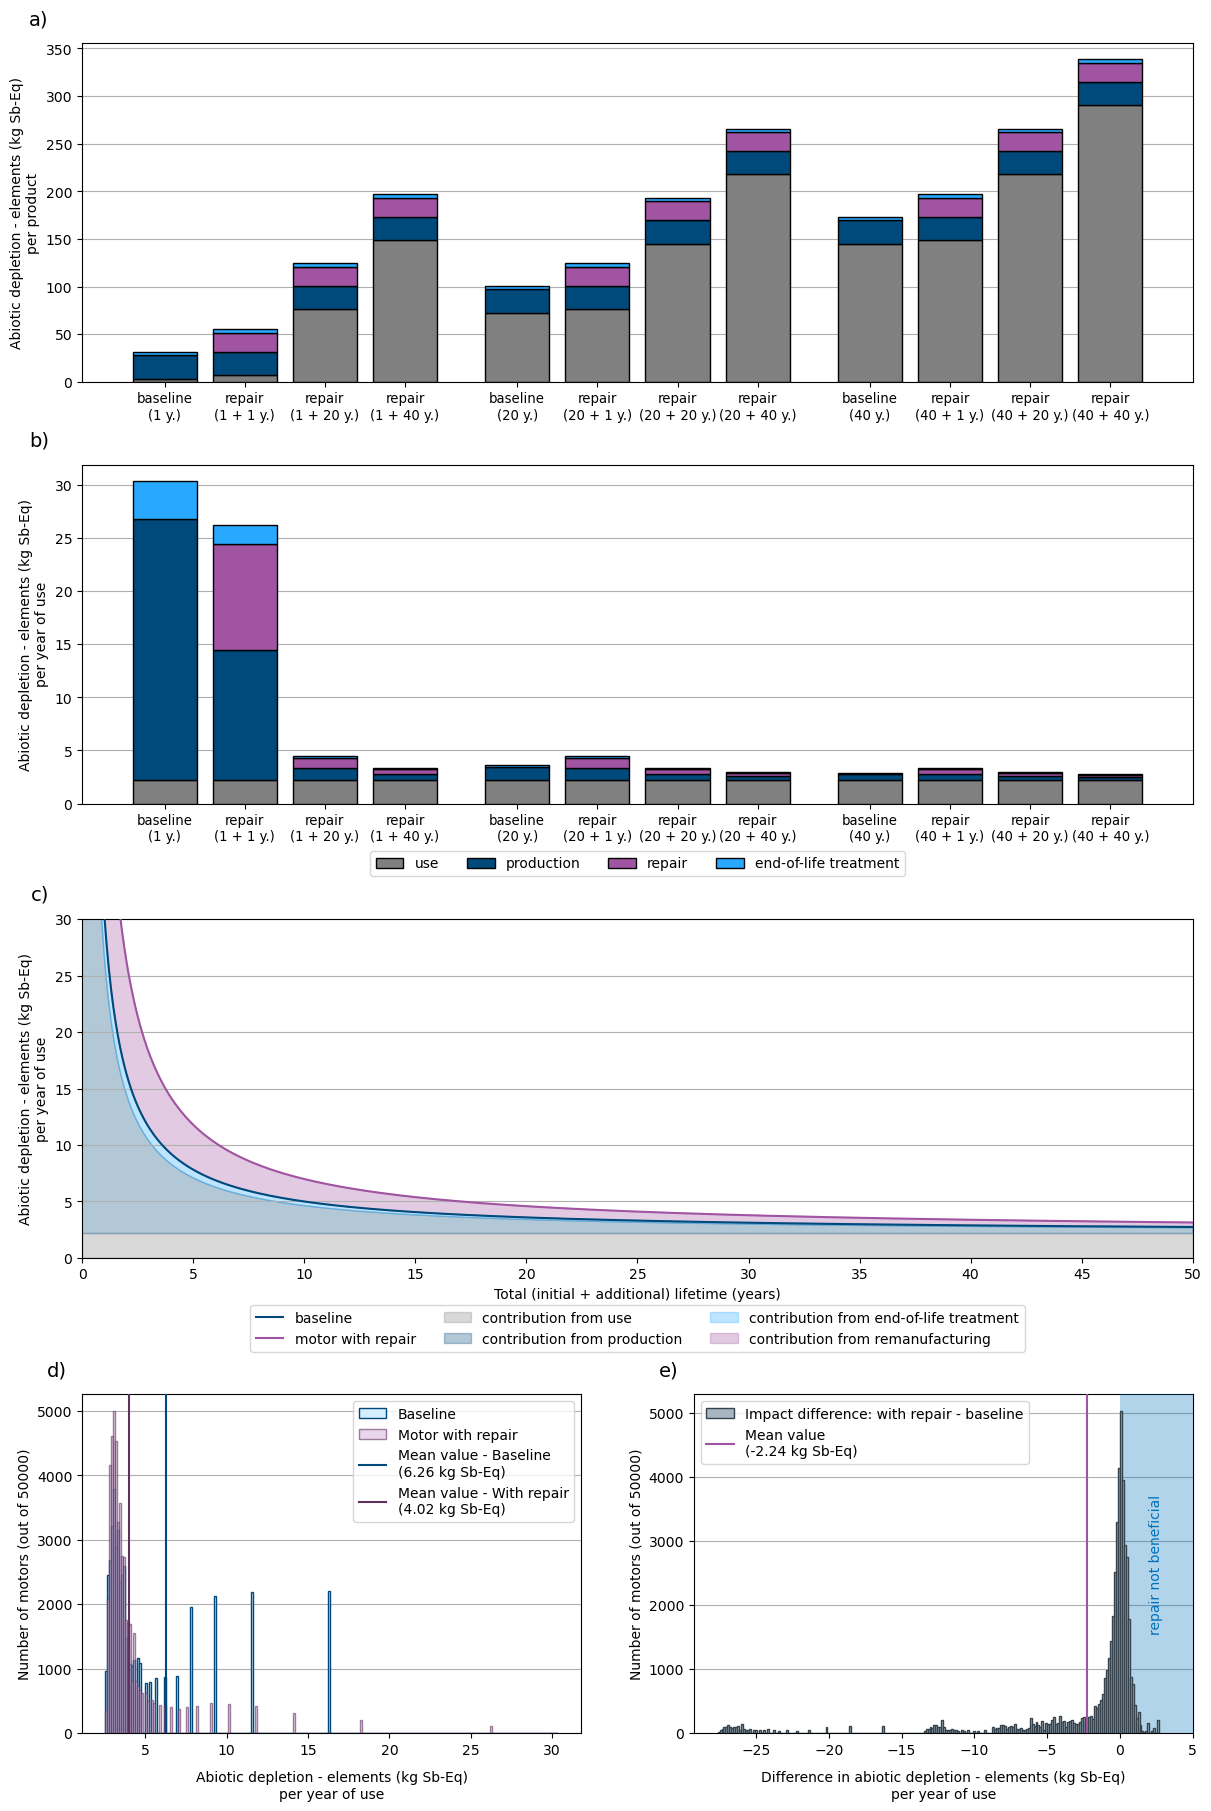

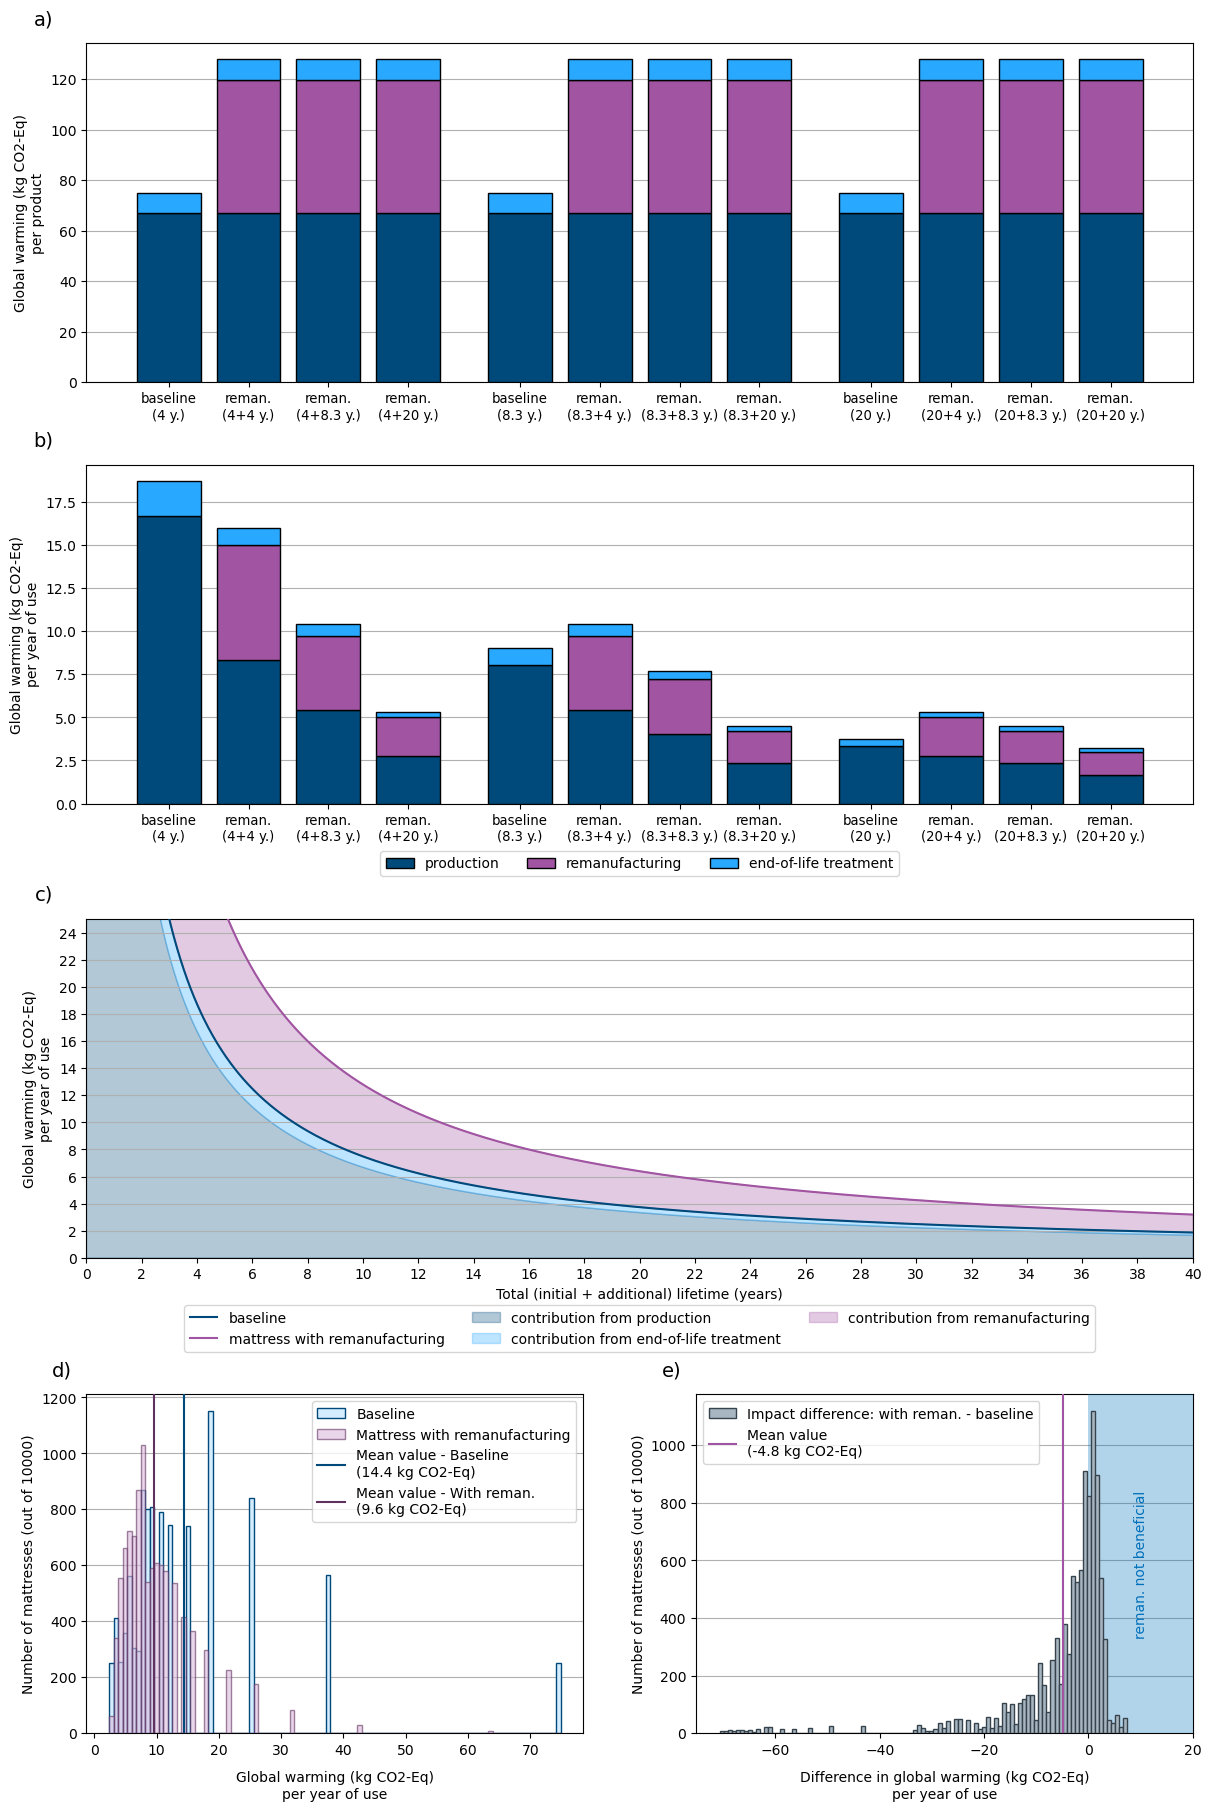

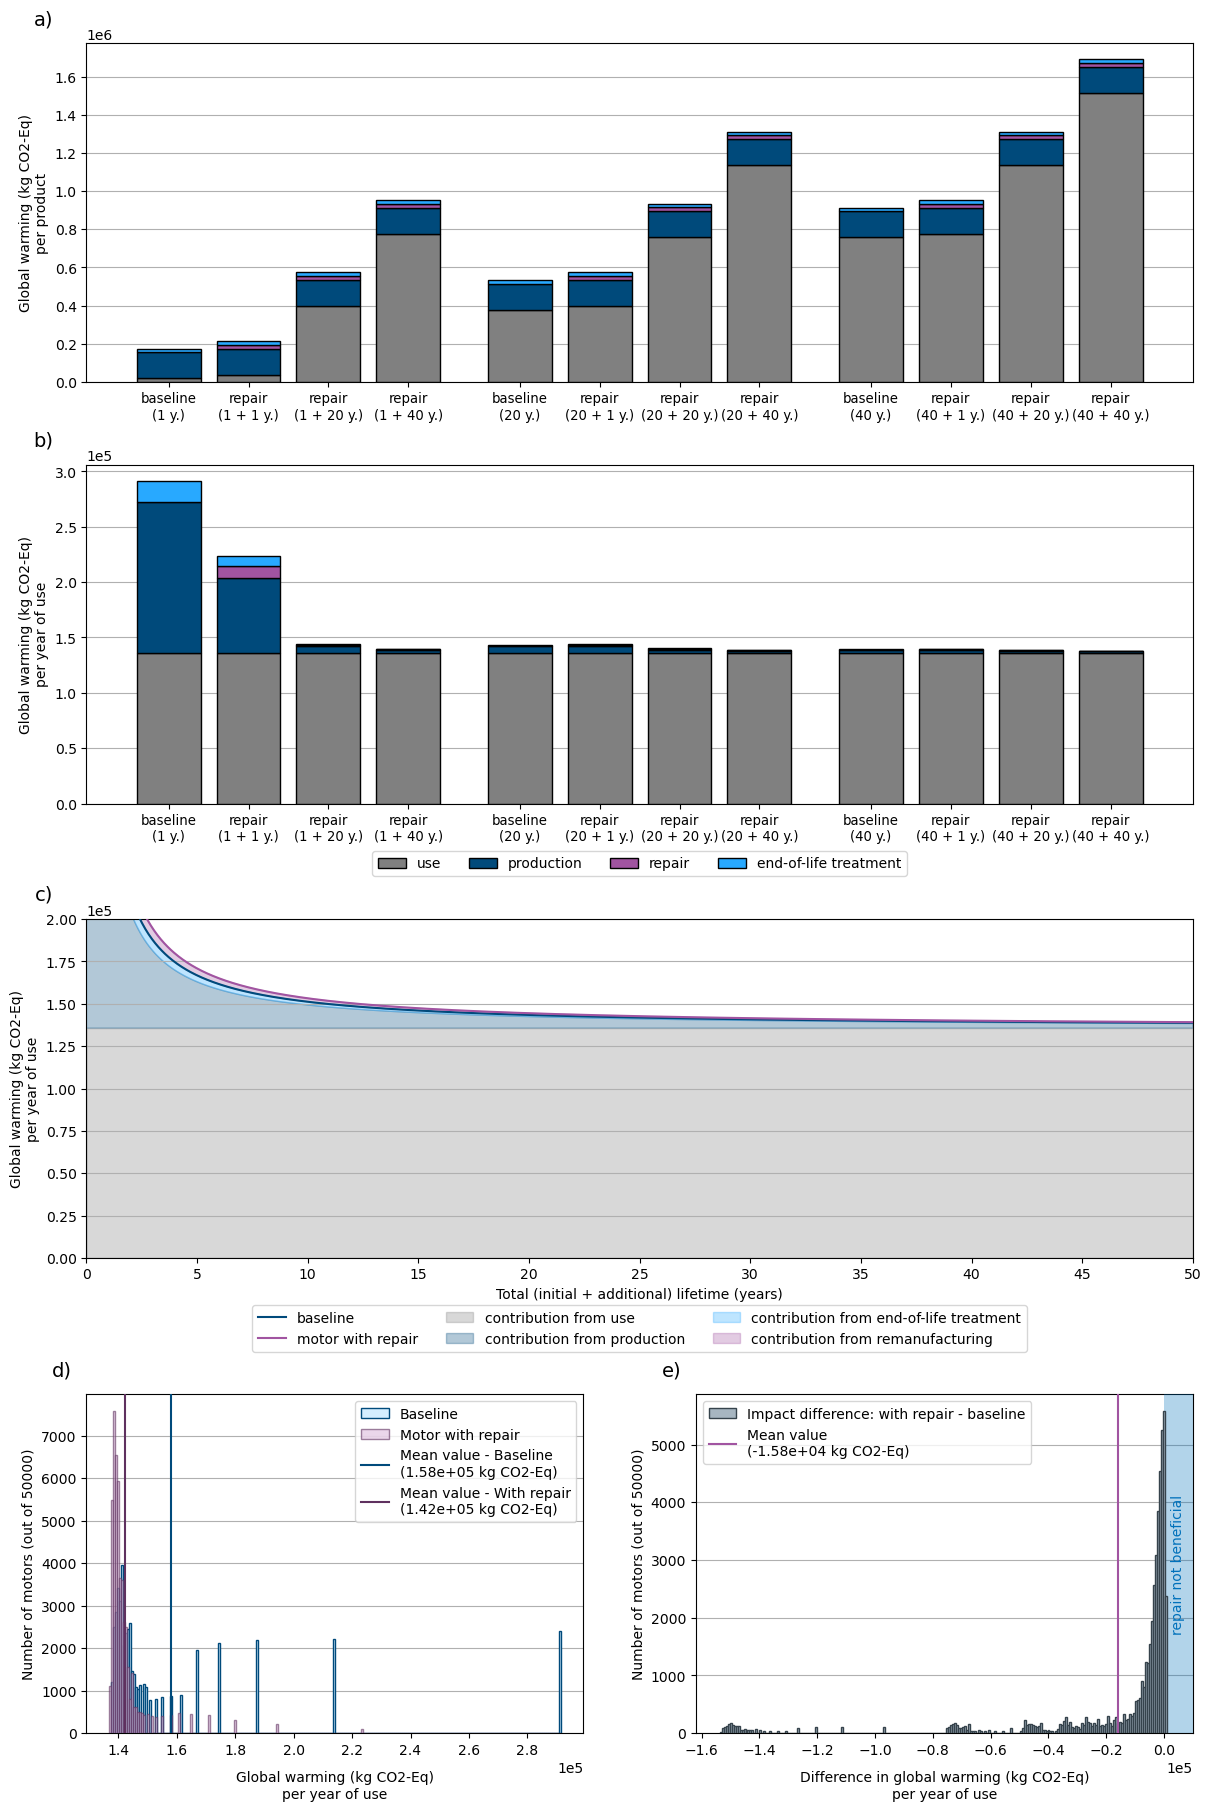

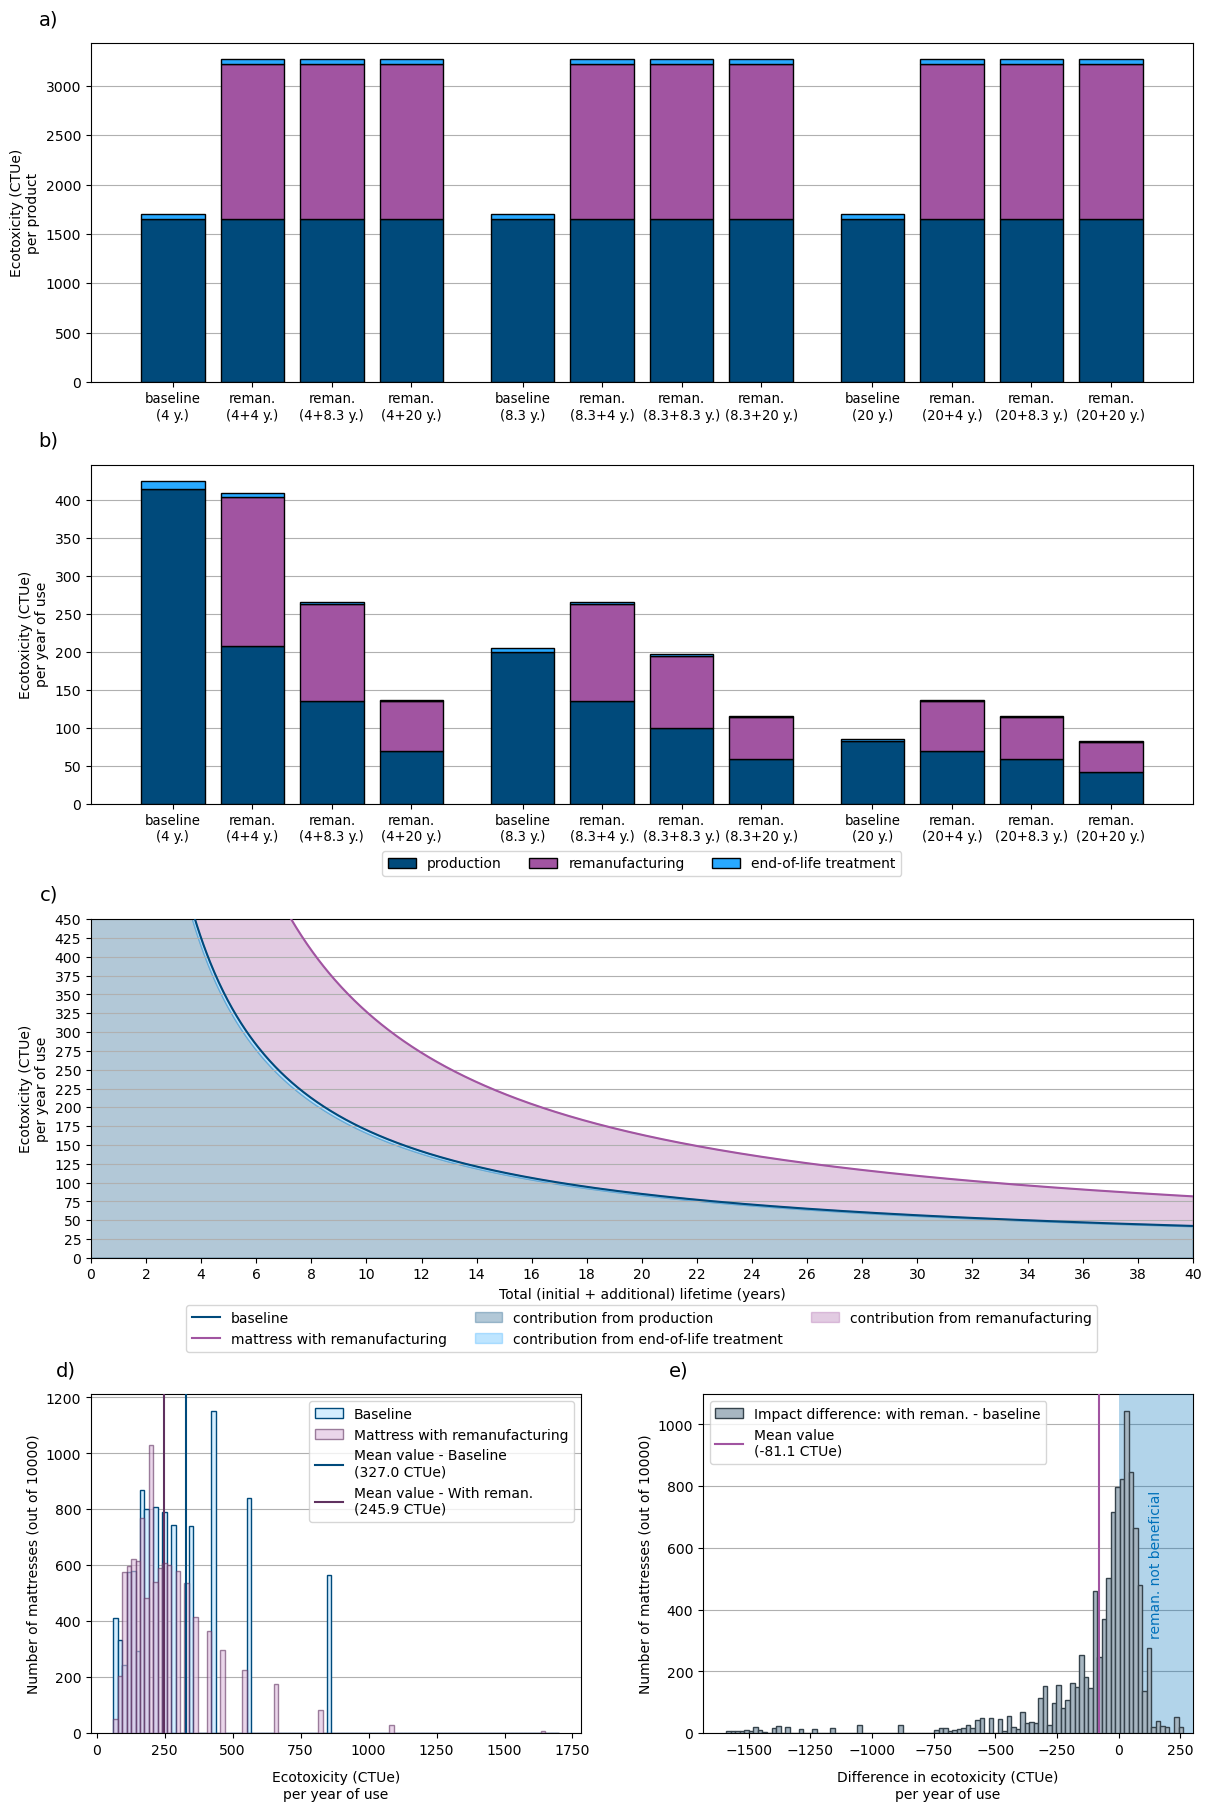

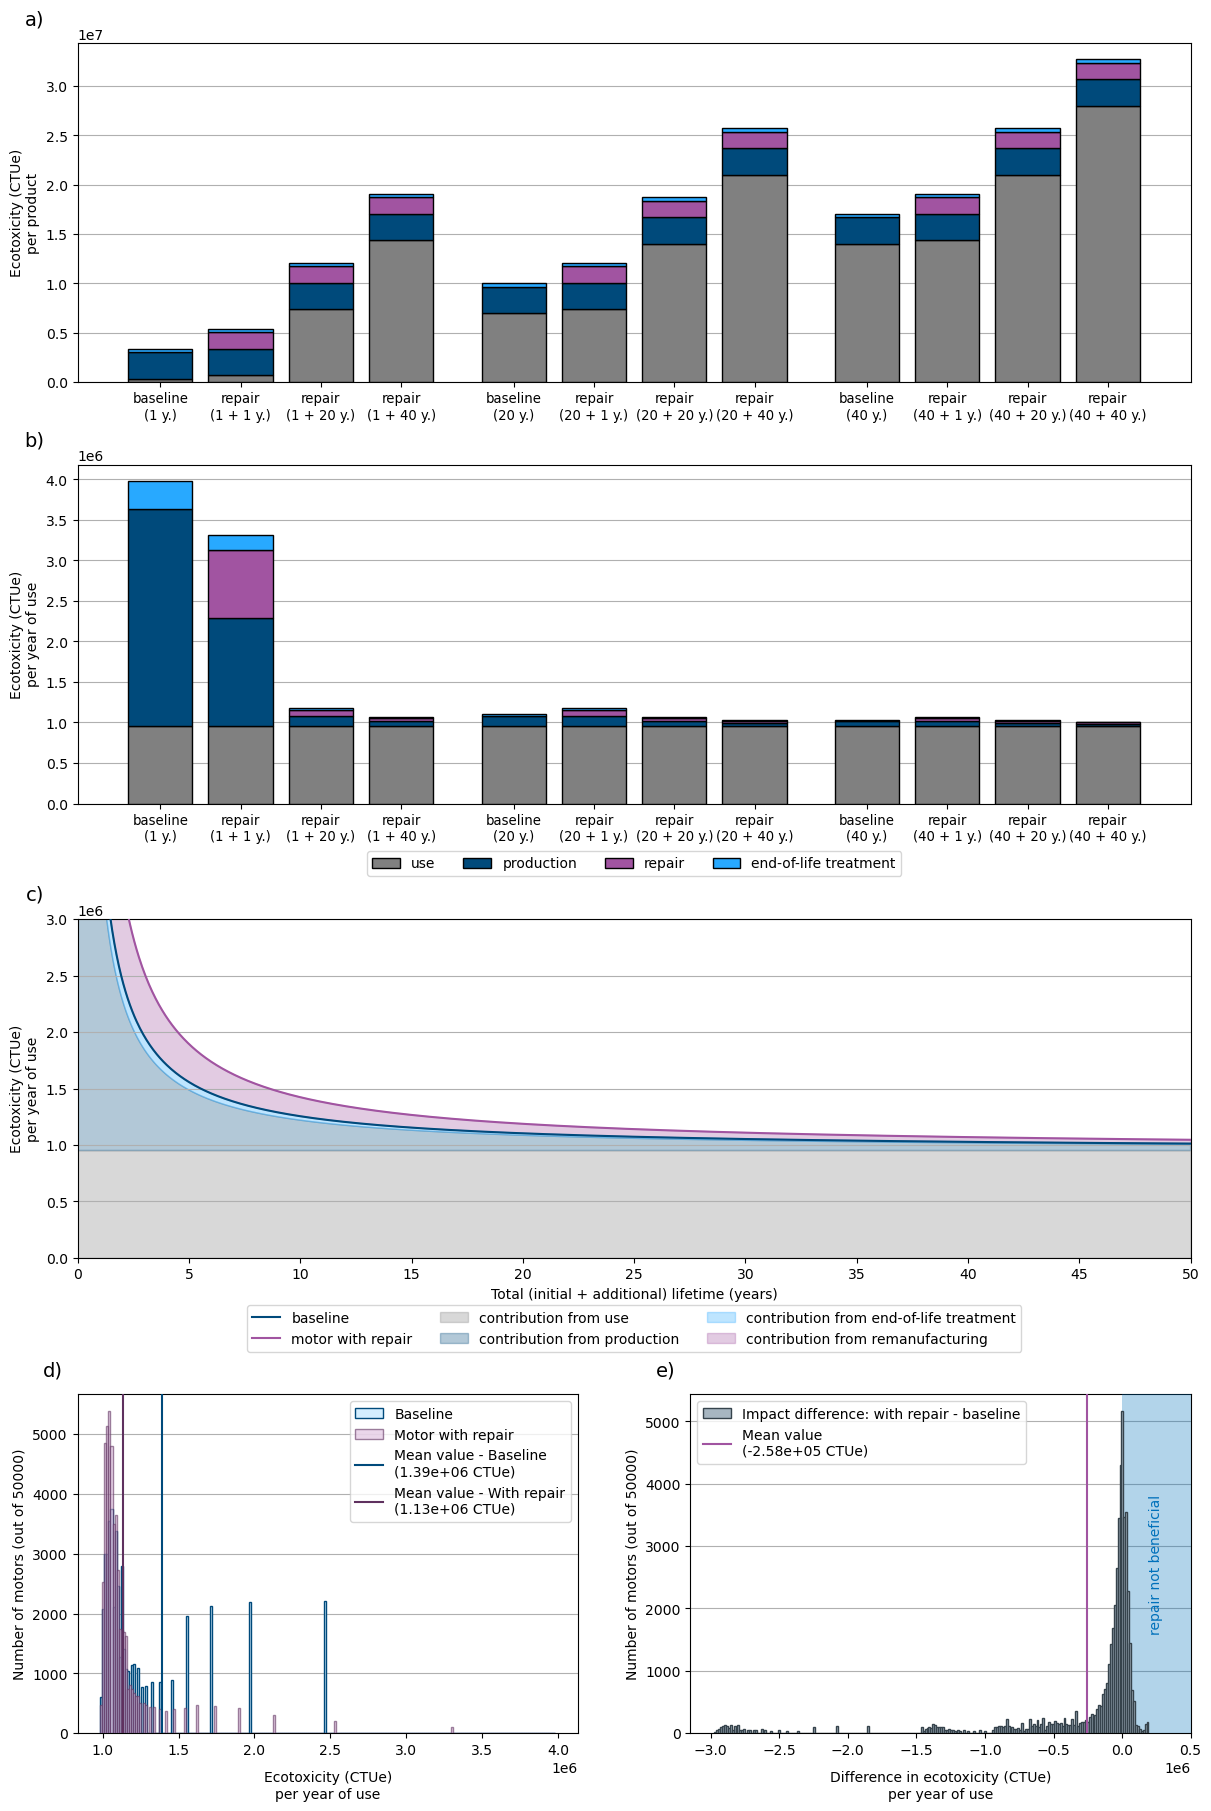

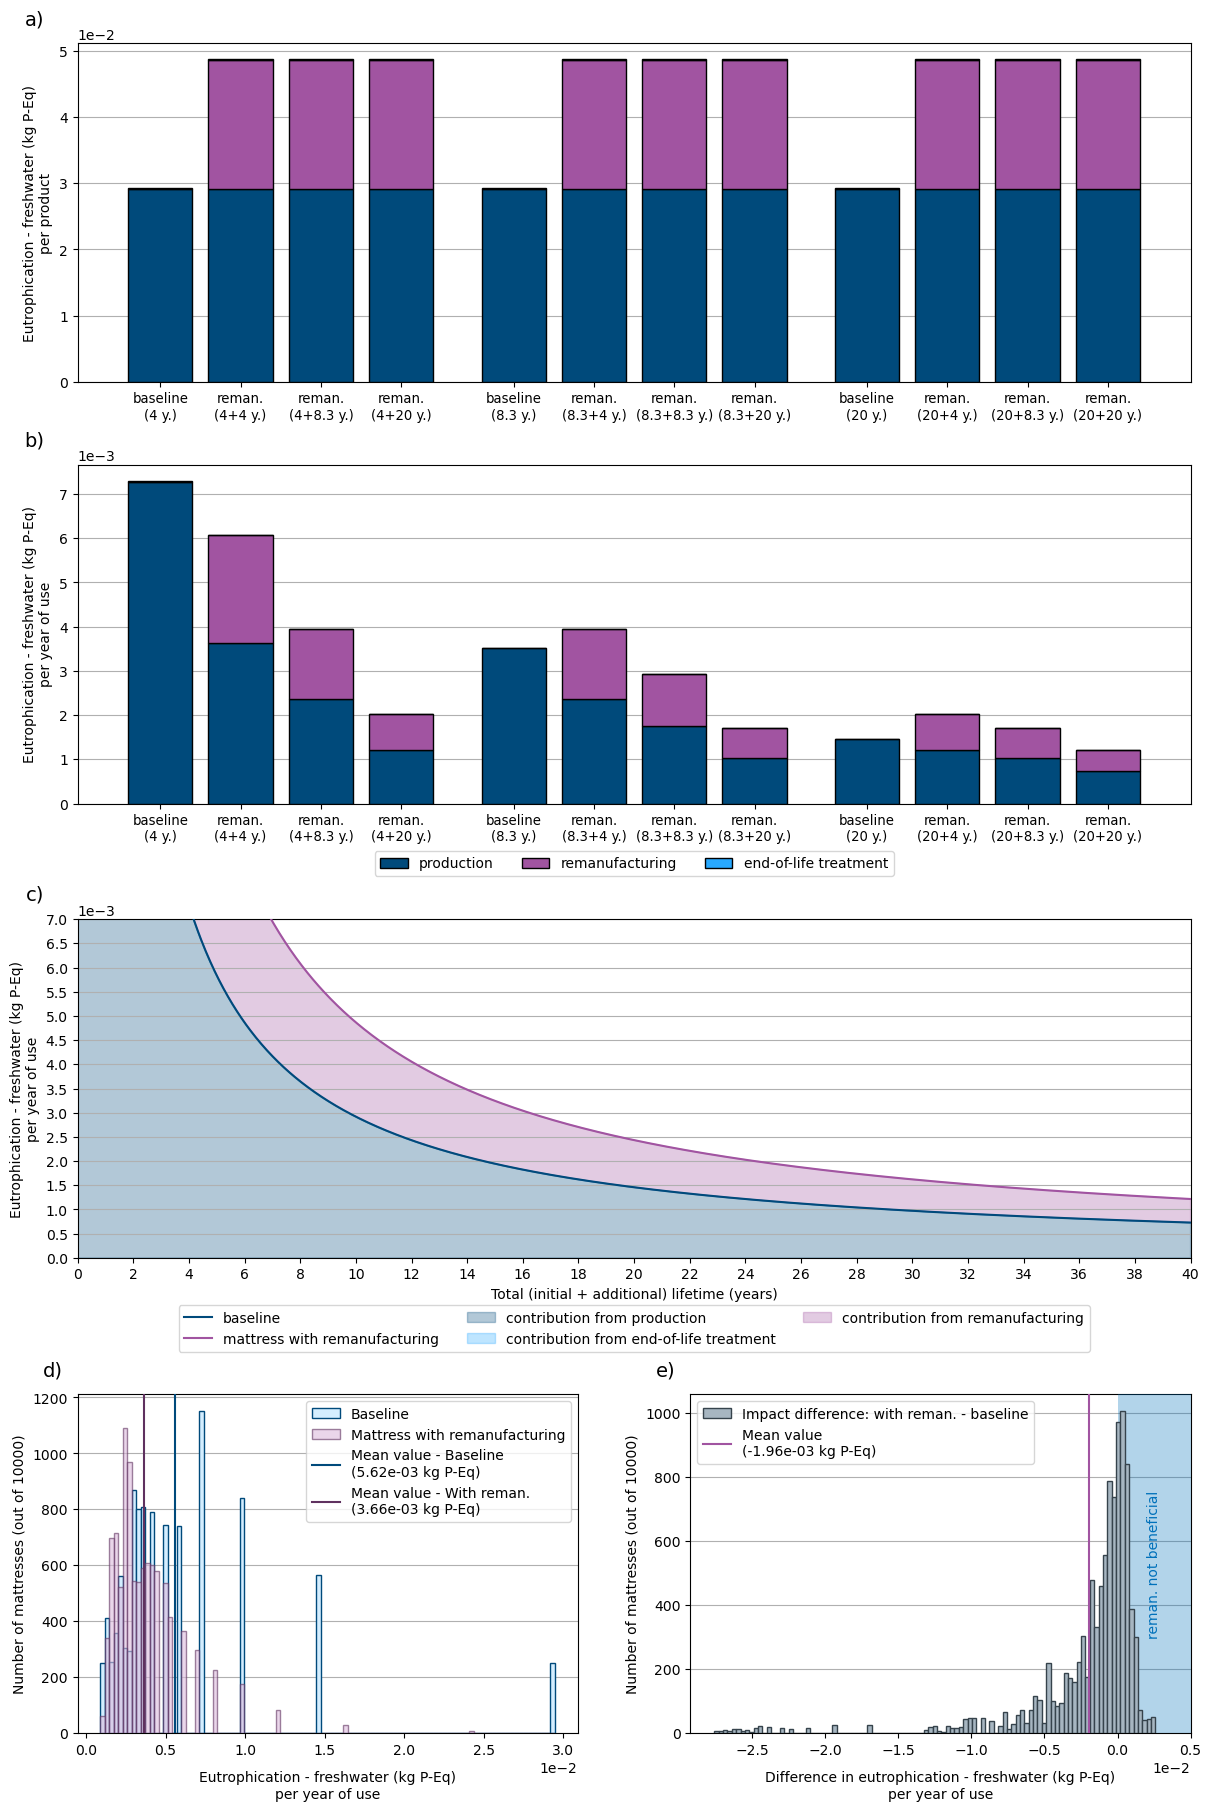

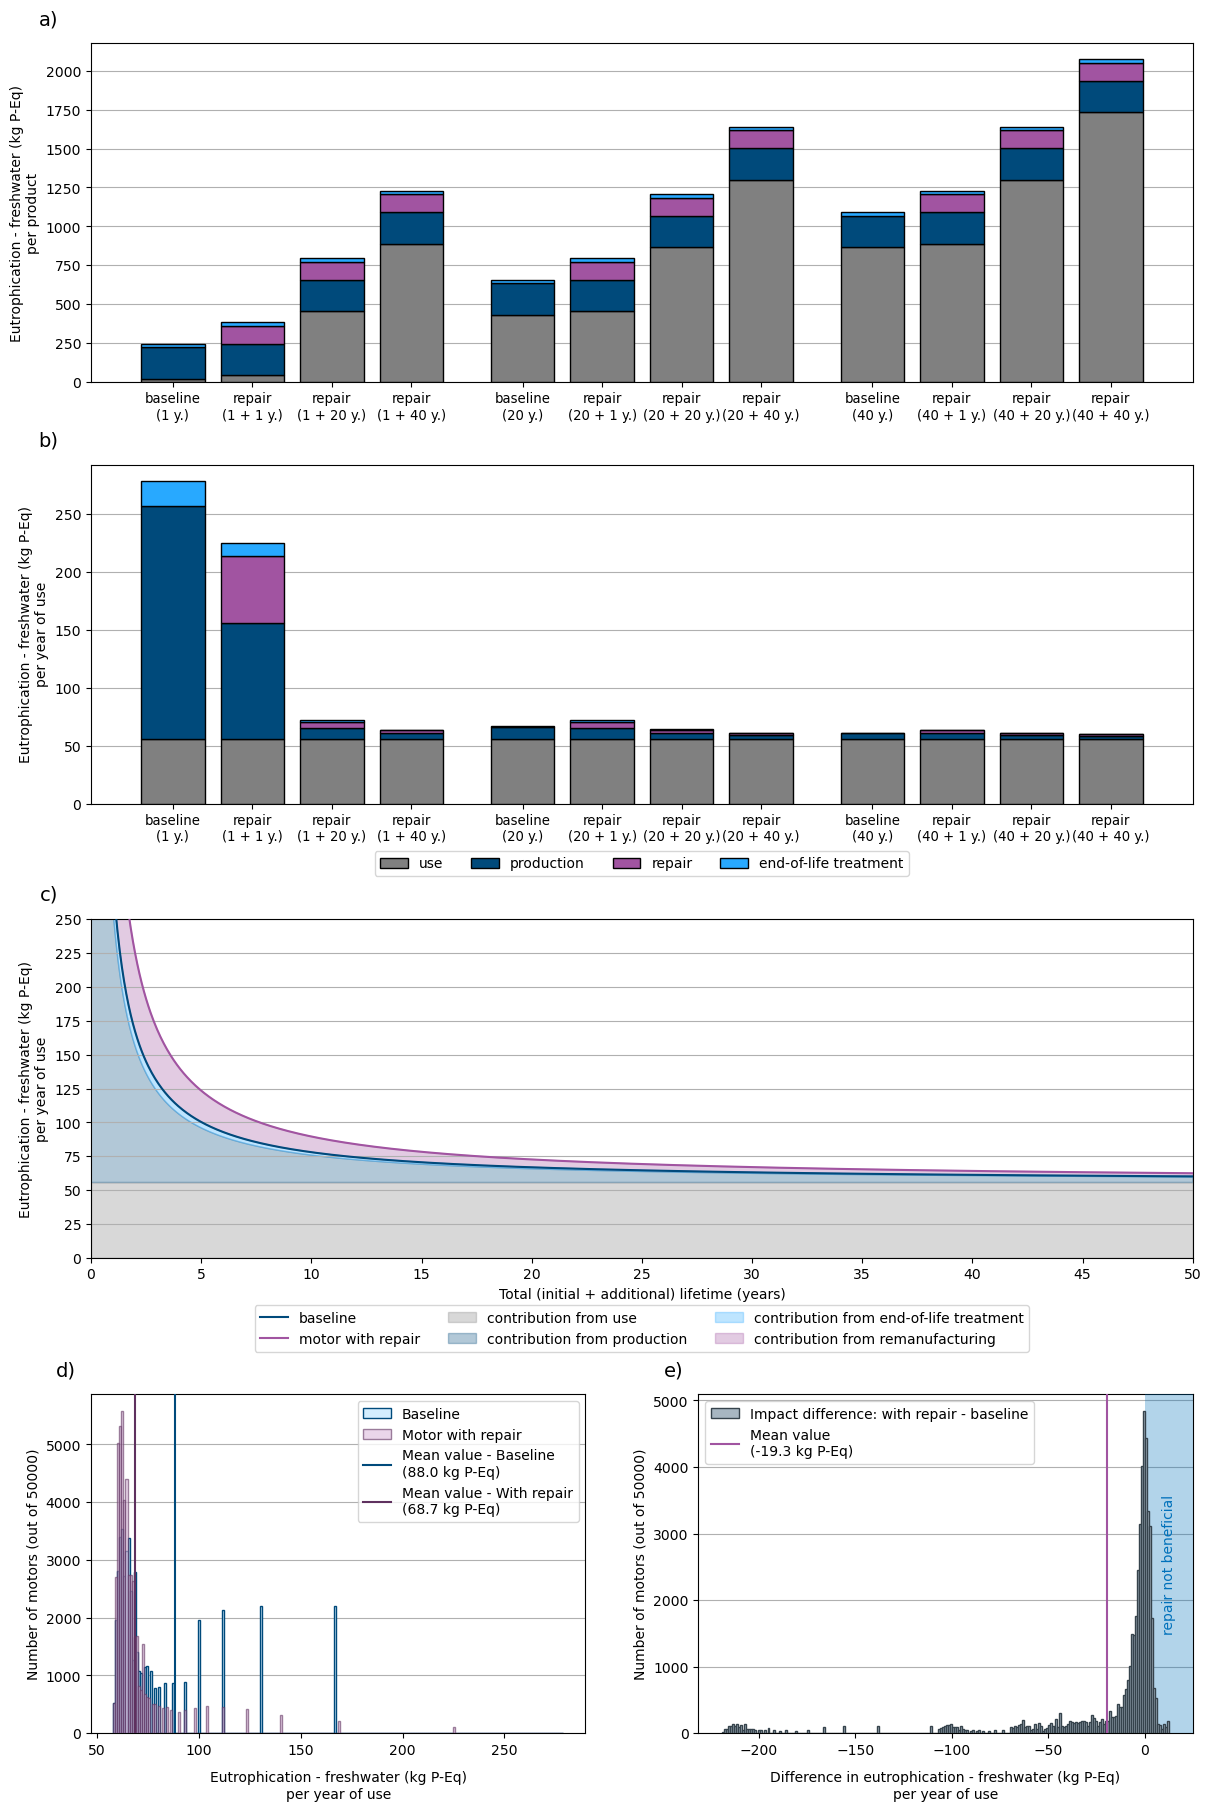

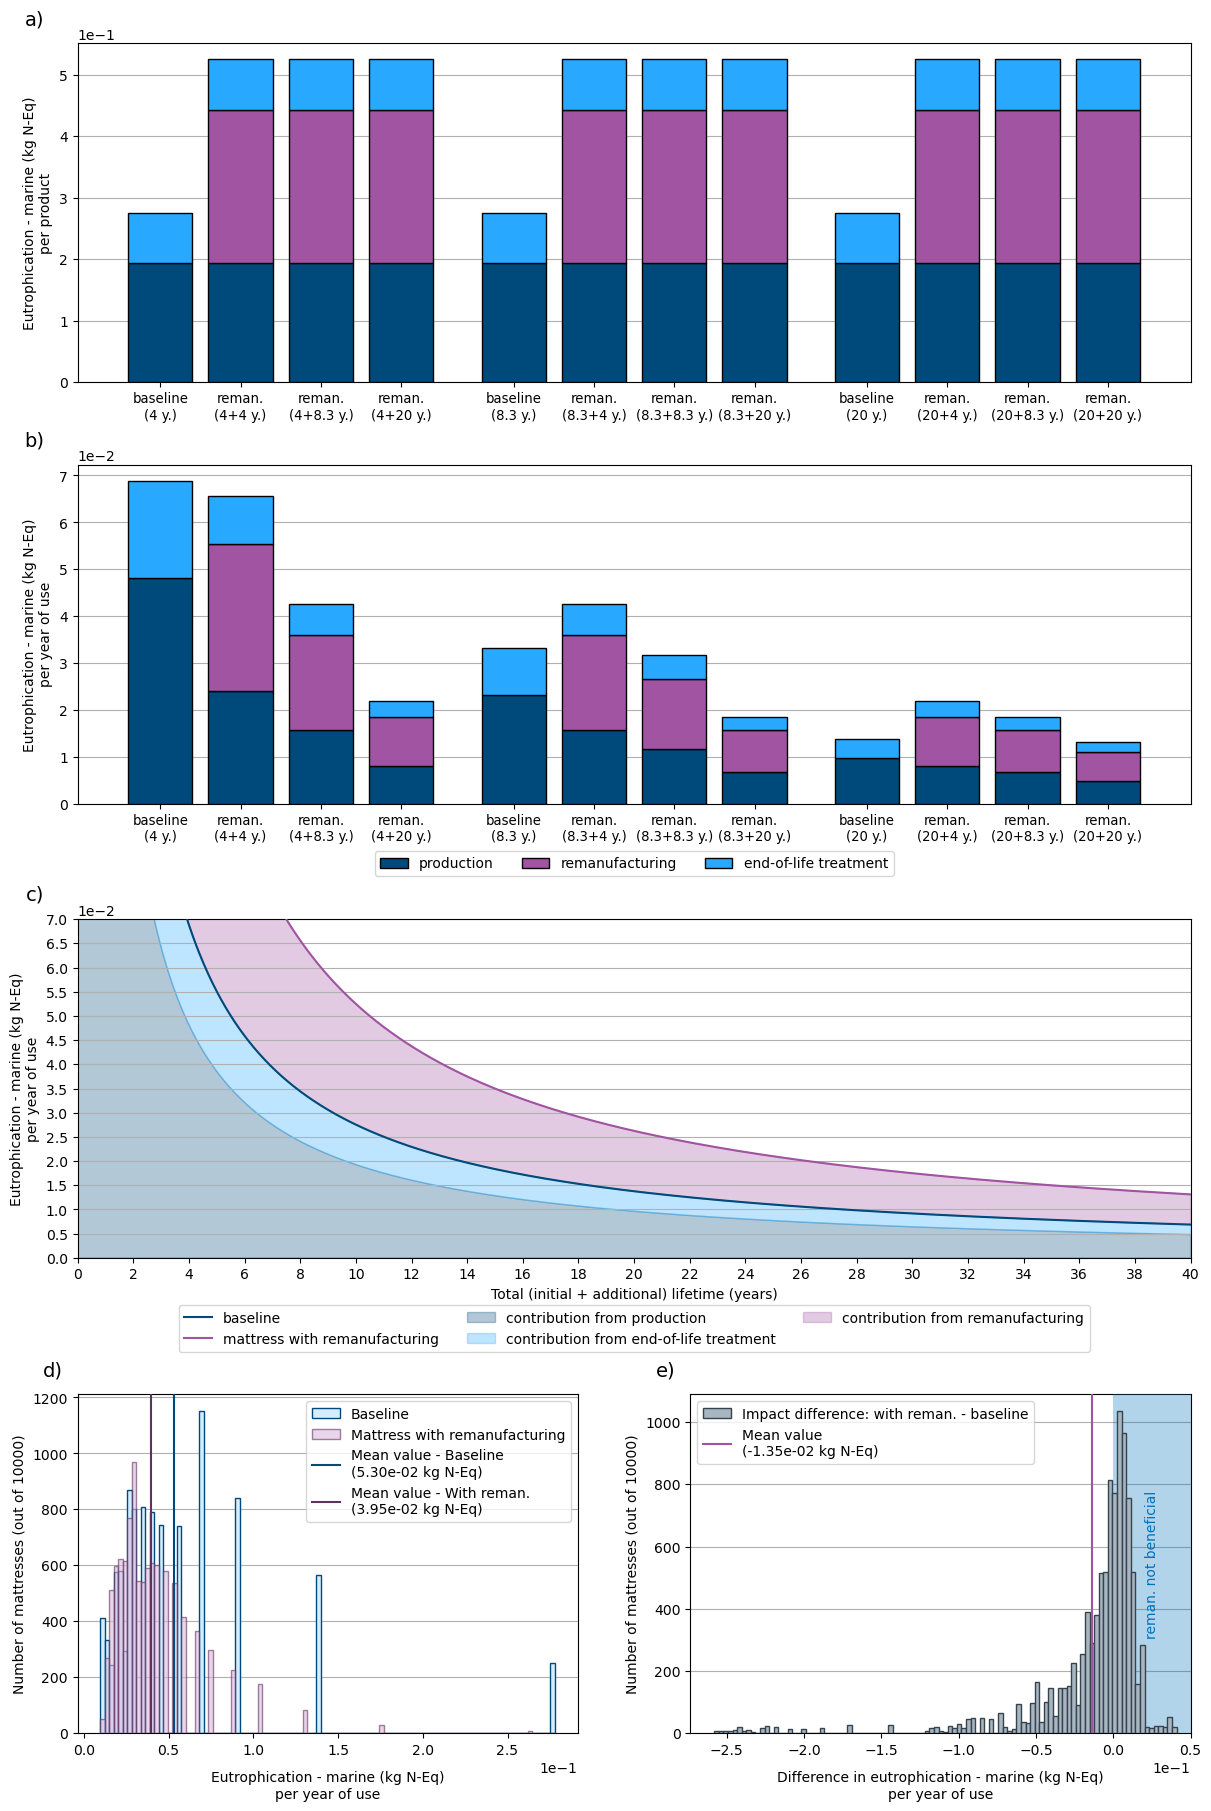

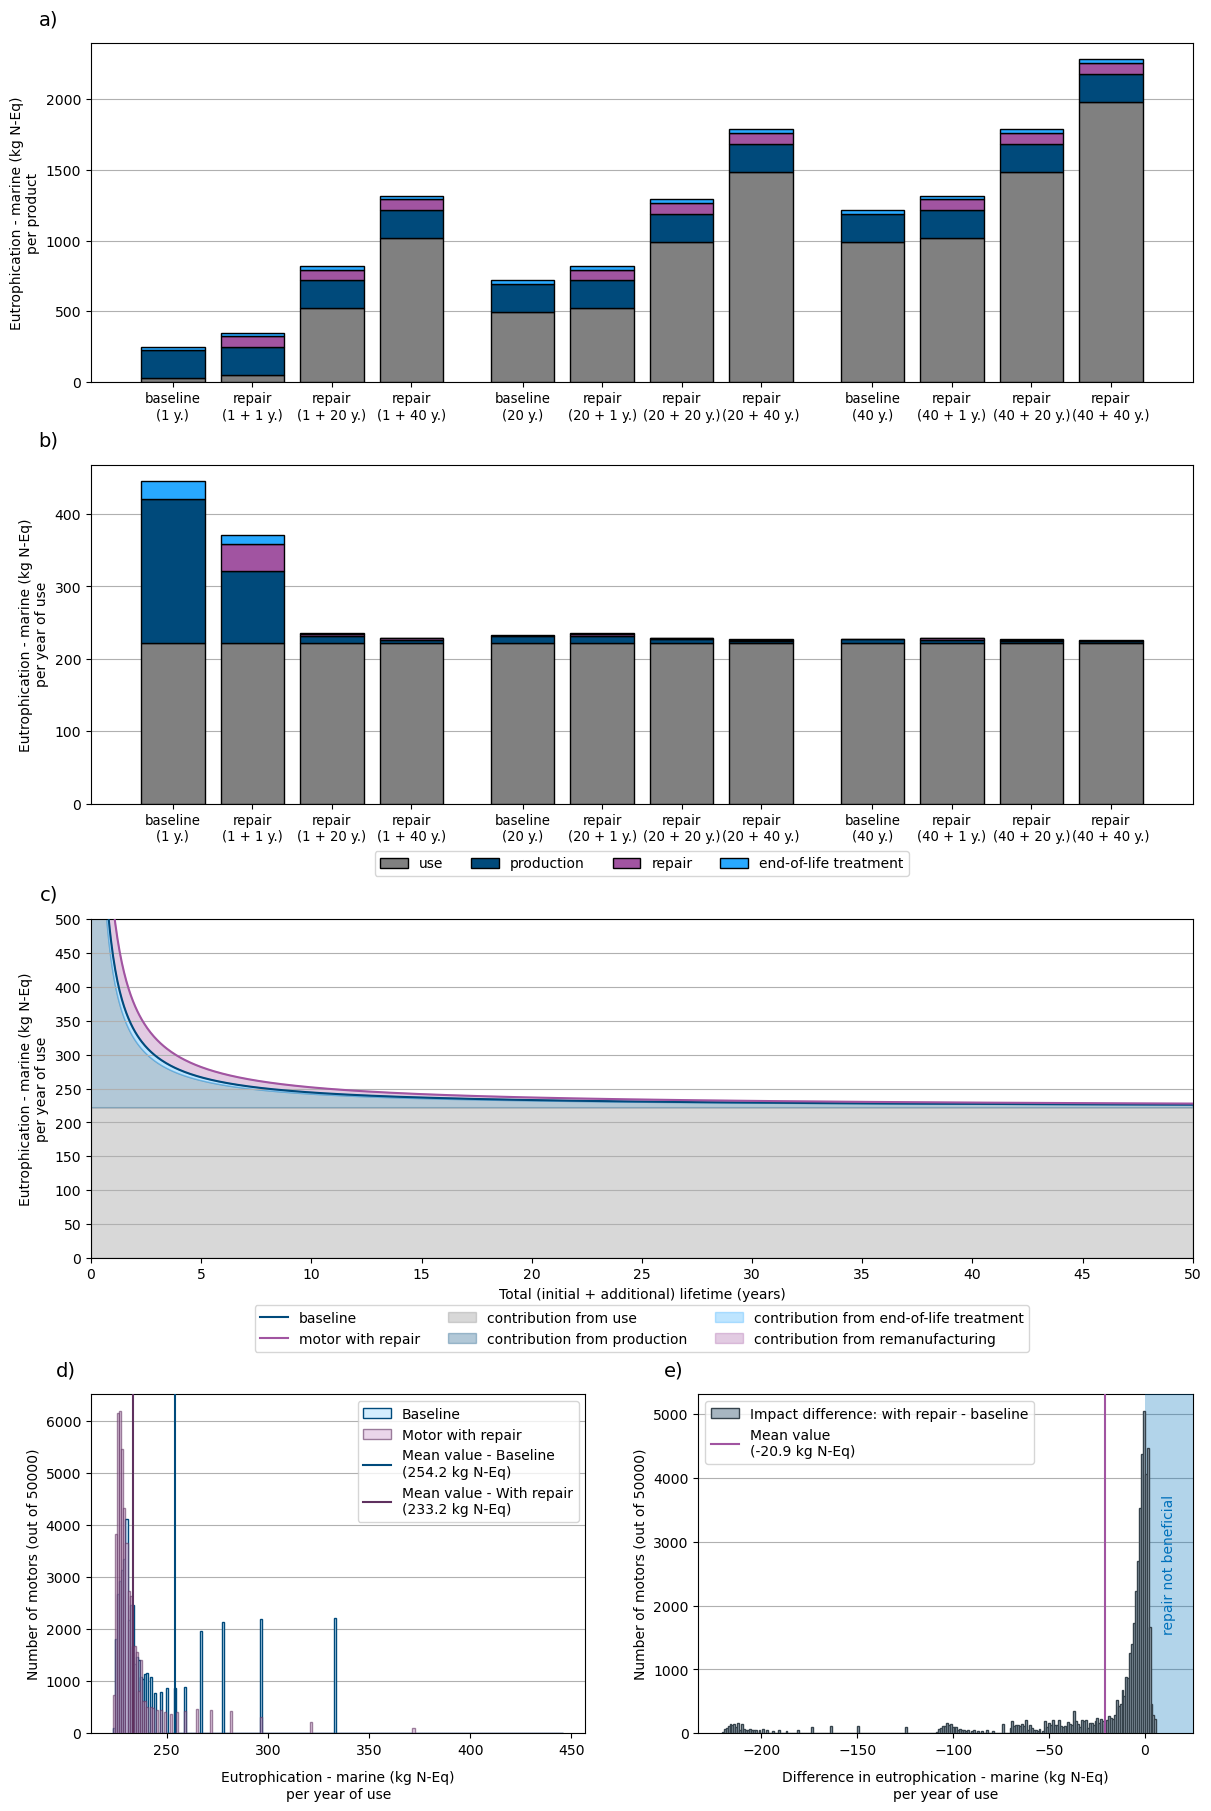

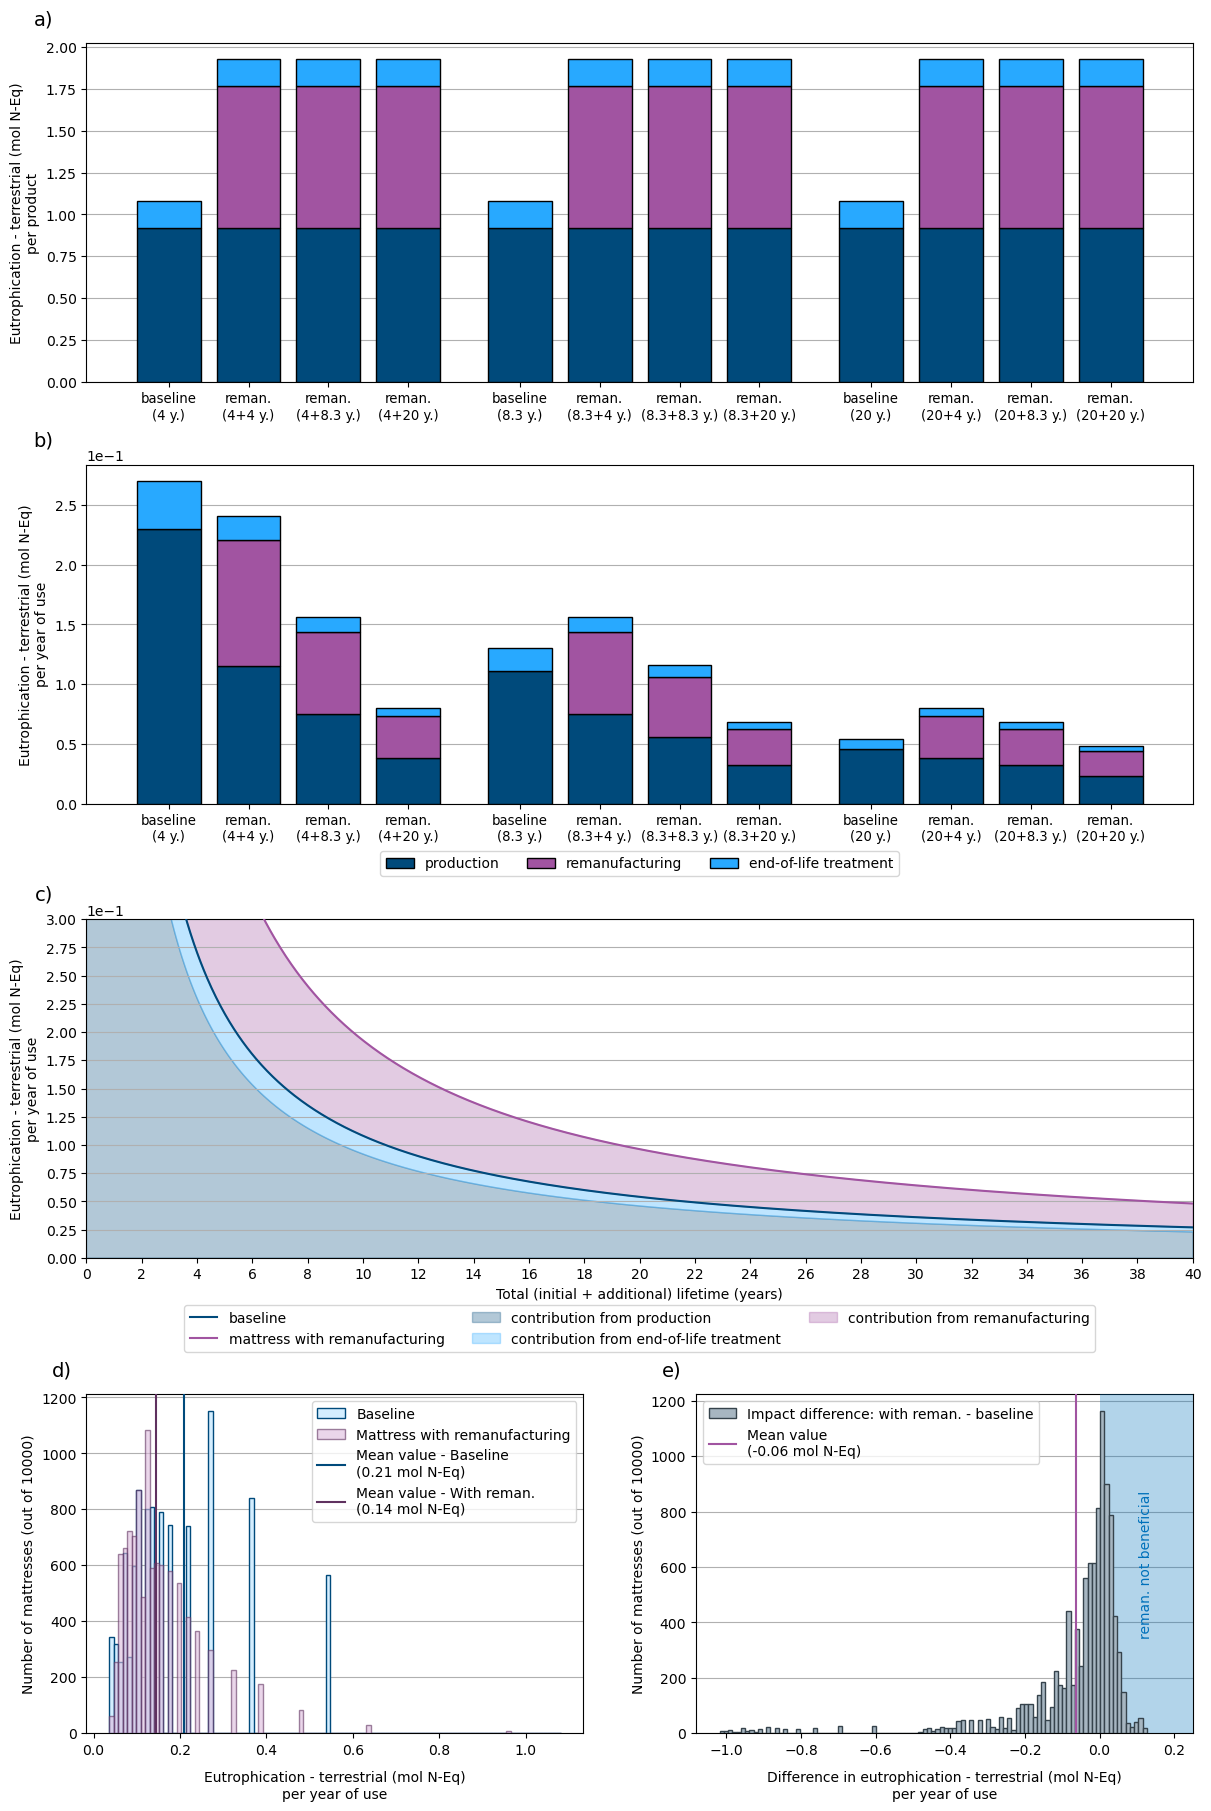

In [ ]:
article_si_all_figures_other_cat(list_methods, list_methods_labels, list_methods_code, list_units)